In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Step 1: Load the dataset
file_path = "vroegtijdig-schoolverlaten-woonplaats-dataset-2022-2023.xlsx"
bad_df = pd.read_excel(file_path)

# Step 2: Transform the dataset
def transform_dataset(bad_df):
    transformed_rows = []

    for _, row in bad_df.iterrows():
        vsv_noemer = row['vsv_noemer']
        vsv_teller = row['vsv_teller']

        # Create duplicates based on vsv_noemer
        for i in range(vsv_noemer):
            new_row = row.copy()
            # Set vsv_teller to 1 for the first vsv_teller rows, 0 for the rest
            new_row['vsv_teller'] = 1 if i < vsv_teller else 0
            transformed_rows.append(new_row)

    # Create a new DataFrame from the transformed rows
    df = pd.DataFrame(transformed_rows)

    # Drop the vsv_noemer column
    df = df.drop(columns=['vsv_noemer'])

    return df

# Apply the transformation
df = transform_dataset(bad_df)

<h1>Characteristics of the dataset</h1>

In [2]:
# Check general characteristics of the dataset
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 71668 entries, 0 to 48996
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   schooljaar                         71668 non-null  object
 1   oki_waarde                         71668 non-null  object
 2   risicokenmerk_buurt                71668 non-null  object
 3   risicokenmerk_thuis_taal           71668 non-null  object
 4   risicokenmerk_opleiding_moeder     71668 non-null  object
 5   risicokenmerk_schooltoelage        71668 non-null  object
 6   graad_leerjaar_secundair           71668 non-null  object
 7   uitstroompositie                   71668 non-null  object
 8   geslacht                           71668 non-null  object
 9   belg_nietbelg                      71668 non-null  object
 10  eu_nieteu                          71668 non-null  object
 11  leeftijdscategorie                 71668 non-null  object


In [3]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
schooljaar                           0
oki_waarde                           0
risicokenmerk_buurt                  0
risicokenmerk_thuis_taal             0
risicokenmerk_opleiding_moeder       0
risicokenmerk_schooltoelage          0
graad_leerjaar_secundair             0
uitstroompositie                     0
geslacht                             0
belg_nietbelg                        0
eu_nieteu                            0
leeftijdscategorie                   0
type_loopbanen_so                    0
gezinstaal_nederlands                0
opleidingsniveau_moeder              0
schoolse_vordering                   0
graad_so                             0
hoofdstructuur                       0
leerjaar                             0
studiegebied                         0
woonplaats_fusiegemeente_nis         0
woonplaats_fusiegemeente_naam        0
woonplaats_fusiegemeente_naam_bhg    0
woonplaats_provincie_naam            0
woonplaats_gewest_naam               0
woonplaa

In [4]:
# Check for duplicate entries
duplicate_entries = df.duplicated().sum()
print(f"\nNumber of Duplicate Entries: {duplicate_entries}")


Number of Duplicate Entries: 22166


In [5]:
# Describe numerical and categorical data
print("\nNumerical Data Description:")
print(df.describe())

print("\nCategorical Data Description:")
print(df.describe(include=['object']))


Numerical Data Description:
         vsv_teller
count  71668.000000
mean       0.131858
std        0.338339
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000

Categorical Data Description:
       schooljaar oki_waarde risicokenmerk_buurt risicokenmerk_thuis_taal  \
count       71668      71668               71668                    71668   
unique          1          5                   3                        3   
top     2022-2023          0                 Nee                      Nee   
freq        71668      31387               52828                    56348   

       risicokenmerk_opleiding_moeder risicokenmerk_schooltoelage  \
count                           71668                       71668   
unique                              3                           3   
top                               Nee                         Nee   
freq                            54309                       43006   

       graad_leerjaar_secund

In [6]:
# Identify outliers using the IQR method
numerical_cols = df.select_dtypes(include=['number']).columns
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).sum()

print("\nOutliers per Numerical Column:")
print(outliers)


Outliers per Numerical Column:
vsv_teller    9450
dtype: int64


In [7]:
# Analyze input data types
print("\nData Types:")
print(df.dtypes)


Data Types:
schooljaar                           object
oki_waarde                           object
risicokenmerk_buurt                  object
risicokenmerk_thuis_taal             object
risicokenmerk_opleiding_moeder       object
risicokenmerk_schooltoelage          object
graad_leerjaar_secundair             object
uitstroompositie                     object
geslacht                             object
belg_nietbelg                        object
eu_nieteu                            object
leeftijdscategorie                   object
type_loopbanen_so                    object
gezinstaal_nederlands                object
opleidingsniveau_moeder              object
schoolse_vordering                   object
graad_so                             object
hoofdstructuur                       object
leerjaar                             object
studiegebied                         object
woonplaats_fusiegemeente_nis         object
woonplaats_fusiegemeente_naam        object
woonplaats_fusiegem

<h1>Imbalances in the dataset</h1>

<h3>Class imbalance</h3>


Class Distribution of Target Variable (vsv_teller):
vsv_teller
0    86.814199
1    13.185801
Name: proportion, dtype: float64


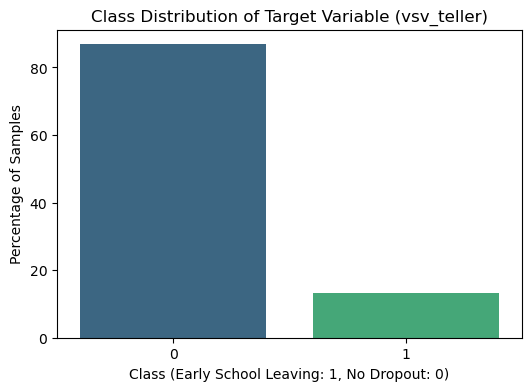

In [8]:
# Check class distribution
class_counts = df['vsv_teller'].value_counts(normalize=True) * 100
print("\nClass Distribution of Target Variable (vsv_teller):")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette="viridis", legend=False)
plt.xlabel("Class (Early School Leaving: 1, No Dropout: 0)")
plt.ylabel("Percentage of Samples")
plt.title("Class Distribution of Target Variable (vsv_teller)")
plt.show()

<h3>Feature imbalance</h3>


Feature Imbalance for schooljaar:
schooljaar
2022-2023    100.0
Name: proportion, dtype: float64


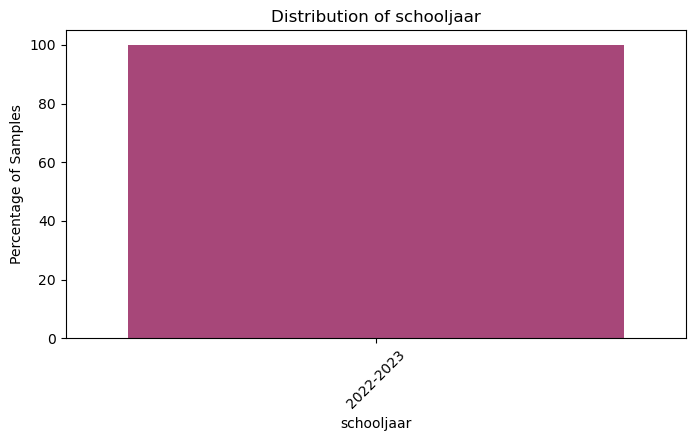


Feature Imbalance for oki_waarde:
oki_waarde
0                   43.794999
1                   25.519060
3,4                 14.028576
2                   13.607189
Niet beschikbaar     3.050176
Name: proportion, dtype: float64


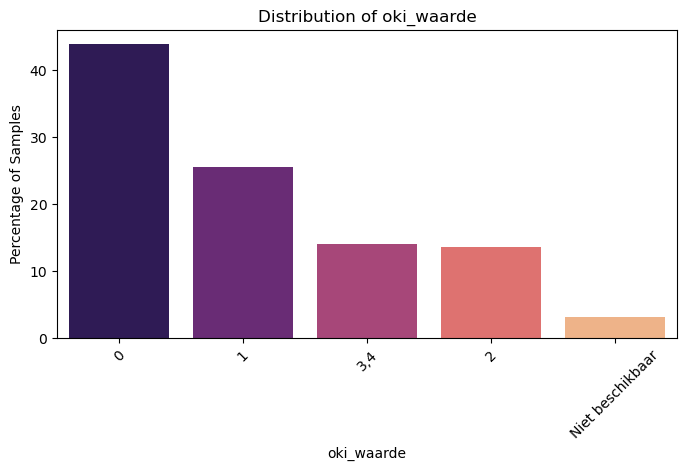


Feature Imbalance for risicokenmerk_buurt:
risicokenmerk_buurt
Nee                 73.712117
Ja                  23.236312
Niet beschikbaar     3.051571
Name: proportion, dtype: float64


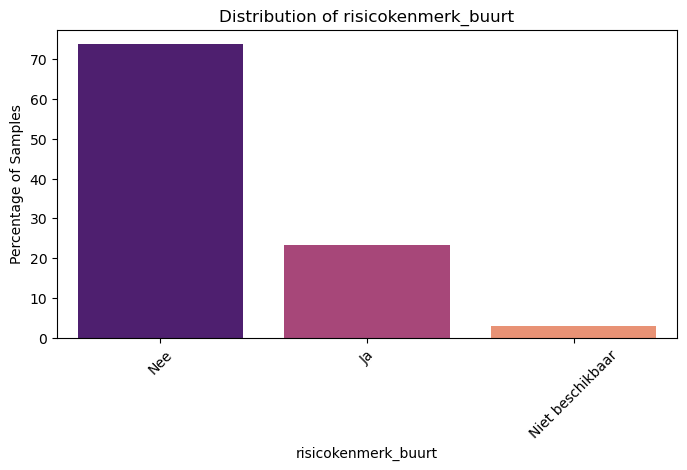


Feature Imbalance for risicokenmerk_thuis_taal:
risicokenmerk_thuis_taal
Nee                 78.623654
Ja                  18.326171
Niet beschikbaar     3.050176
Name: proportion, dtype: float64


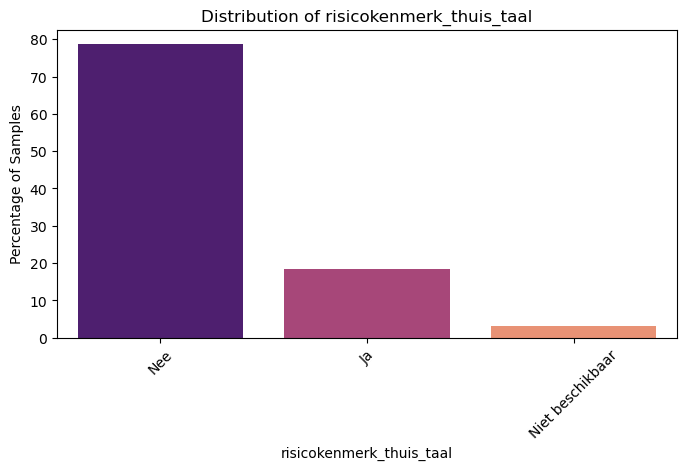


Feature Imbalance for risicokenmerk_opleiding_moeder:
risicokenmerk_opleiding_moeder
Nee                 75.778590
Ja                  21.171234
Niet beschikbaar     3.050176
Name: proportion, dtype: float64


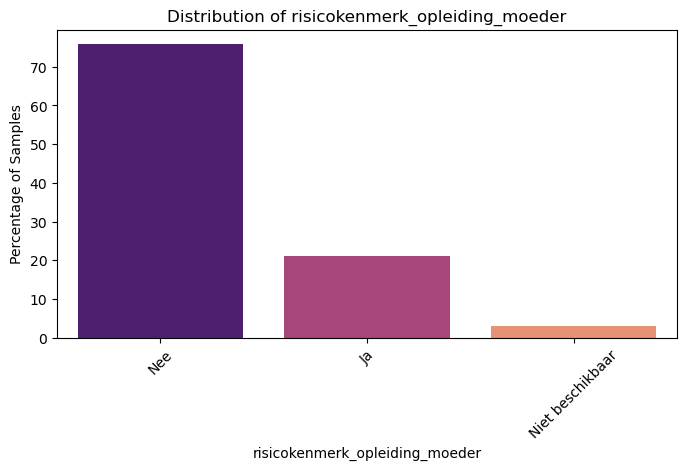


Feature Imbalance for risicokenmerk_schooltoelage:
risicokenmerk_schooltoelage
Nee                 60.007256
Ja                  36.942569
Niet beschikbaar     3.050176
Name: proportion, dtype: float64


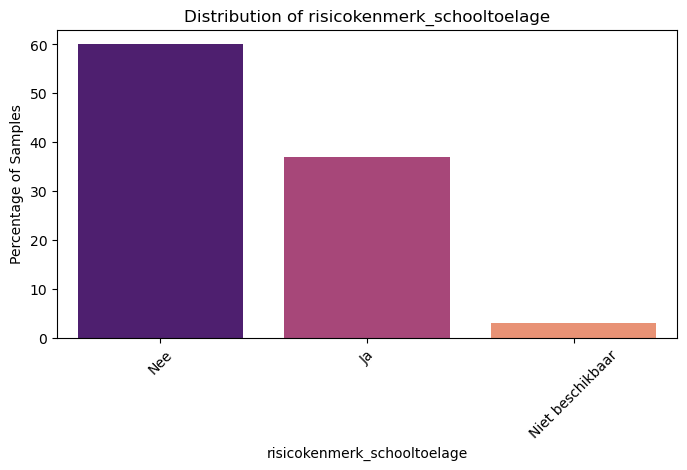


Feature Imbalance for graad_leerjaar_secundair:
graad_leerjaar_secundair
3e graad - 2e leerjaar    86.480717
n.v.t.                     6.004074
3e graad - 1e leerjaar     4.945024
2e graad - 2e leerjaar     1.859965
2e graad - 1e leerjaar     0.665569
Name: proportion, dtype: float64


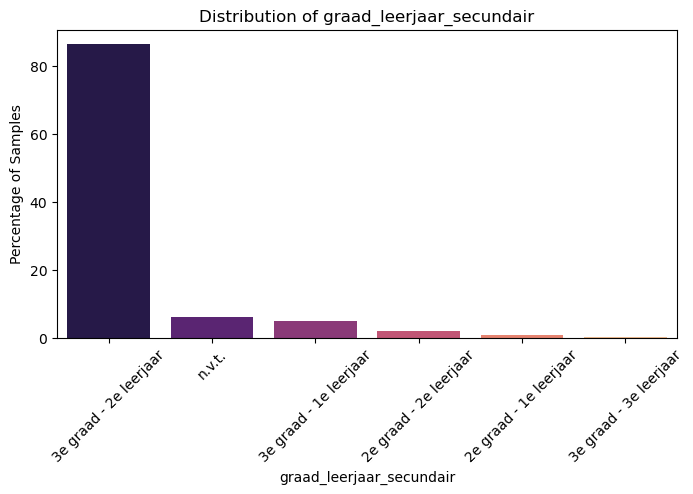


Feature Imbalance for uitstroompositie:
uitstroompositie
aso     37.036055
tso     30.733382
bso     21.753084
dbso     4.485963
kso      2.646927
Name: proportion, dtype: float64


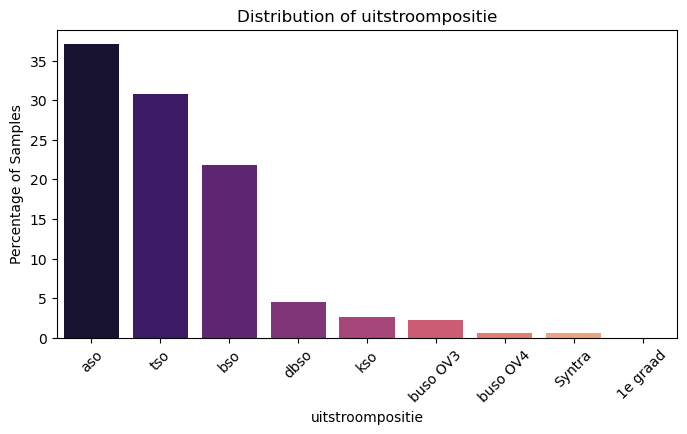


Feature Imbalance for geslacht:
geslacht
Mannelijk     51.438578
Vrouwelijk    48.561422
Name: proportion, dtype: float64


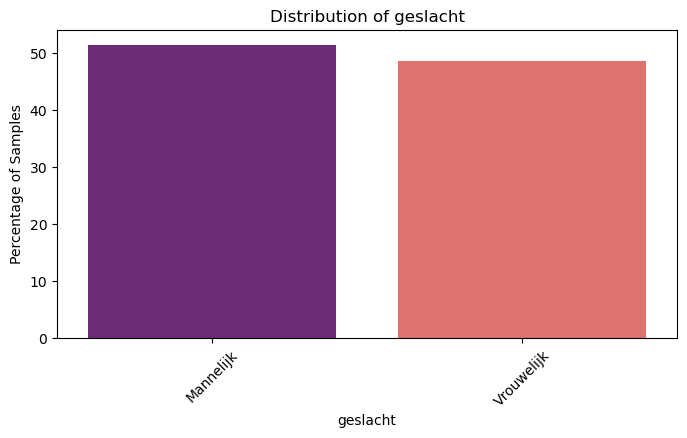


Feature Imbalance for belg_nietbelg:
belg_nietbelg
Belg         91.109003
niet-Belg     8.890997
Name: proportion, dtype: float64


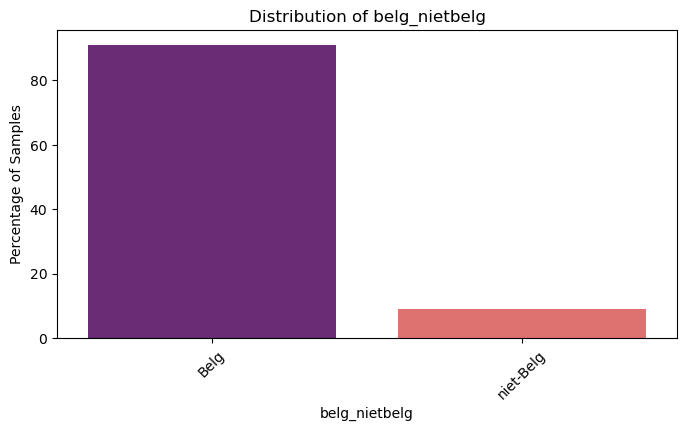


Feature Imbalance for eu_nieteu:
eu_nieteu
EU         96.295418
niet-EU     3.704582
Name: proportion, dtype: float64


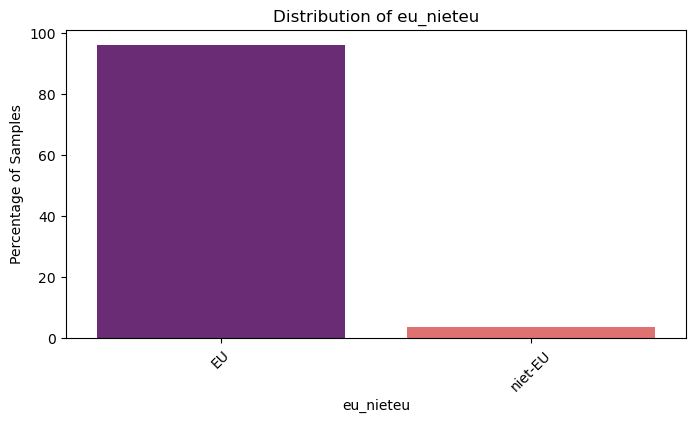


Feature Imbalance for leeftijdscategorie:
leeftijdscategorie
17-18     68.937322
18-19     22.531674
19-20      5.150137
<17-18     1.852989
20-21      1.202768
Name: proportion, dtype: float64


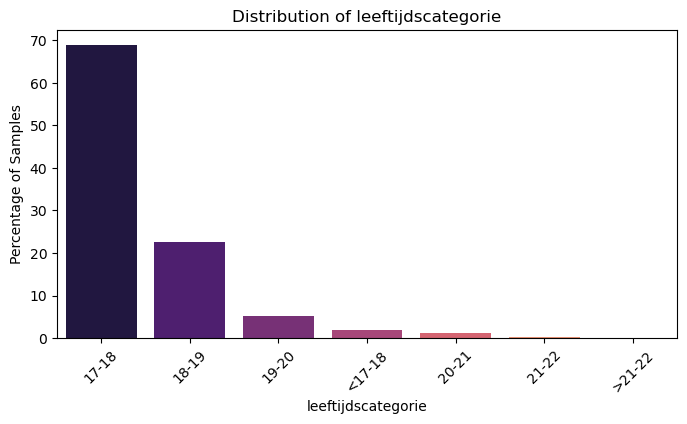


Feature Imbalance for type_loopbanen_so:
type_loopbanen_so
1A-2A-4ASO-EASO    36.208629
1A-2A-4TSO-ETSO    23.338170
Andere             12.901155
1B-2B-4BSO-EBSO     8.758442
1A-2A-4ASO-ETSO     6.153374
Name: proportion, dtype: float64


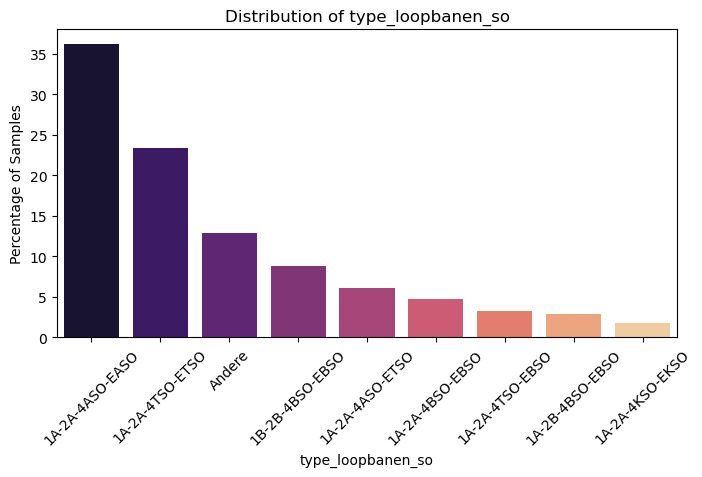


Feature Imbalance for gezinstaal_nederlands:
gezinstaal_nederlands
Uitsluitend Ned met allen    68.981972
Ned met minstens 1           14.688564
Ned met niemand              13.005805
n.v.t.                        3.019479
Onbekend                      0.304180
Name: proportion, dtype: float64


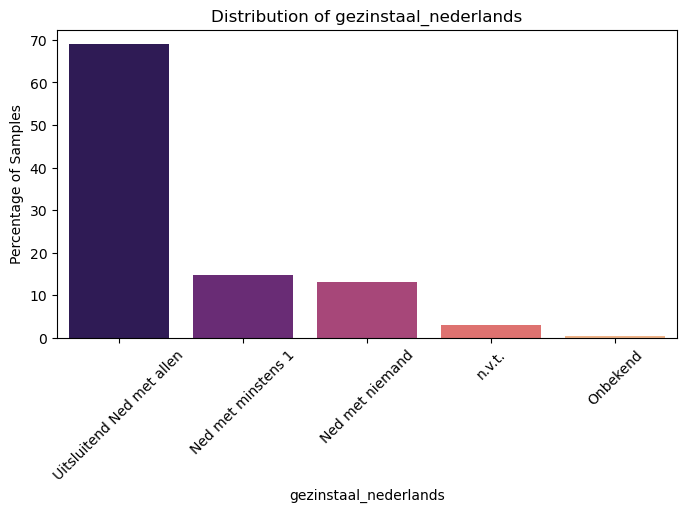


Feature Imbalance for opleidingsniveau_moeder:
opleidingsniveau_moeder
Hoger onderwijs              42.551766
Hoger secundair onderwijs    32.368700
Lager secundair onderwijs    11.738851
Lager onderwijs               5.254786
Geen lager onderwijs          4.177597
Name: proportion, dtype: float64


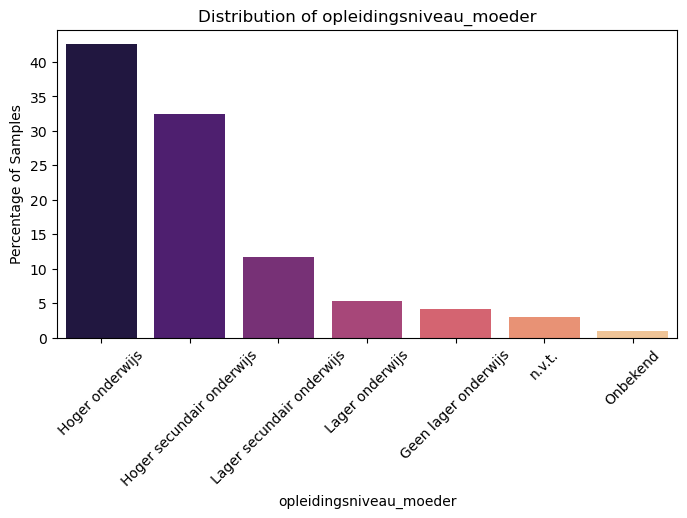


Feature Imbalance for schoolse_vordering:
schoolse_vordering
Geen schoolse achterstand               62.465815
1 jaar schoolse achterstand             22.325166
2 jaar schoolse achterstand              7.007311
n.v.t.                                   6.170118
Meer dan 2 jaar schoolse achterstand     2.031590
Name: proportion, dtype: float64


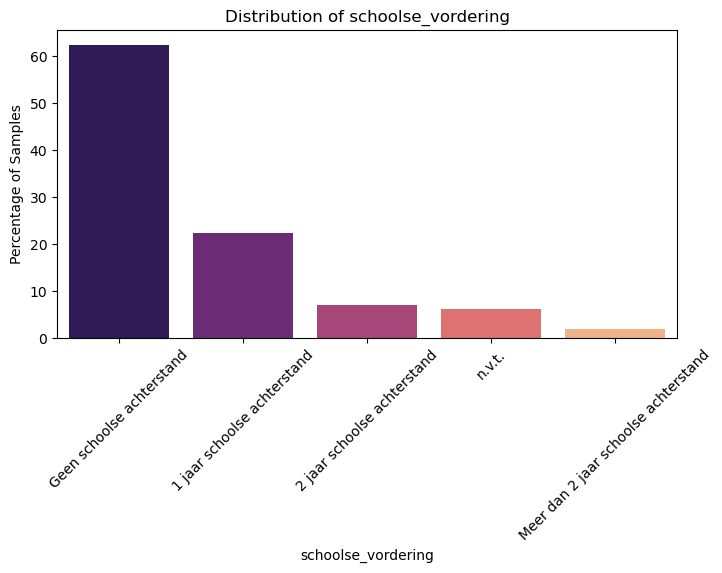


Feature Imbalance for graad_so:
graad_so
3         91.470391
n.v.t.     6.002679
2          2.525534
1          0.001395
Name: proportion, dtype: float64


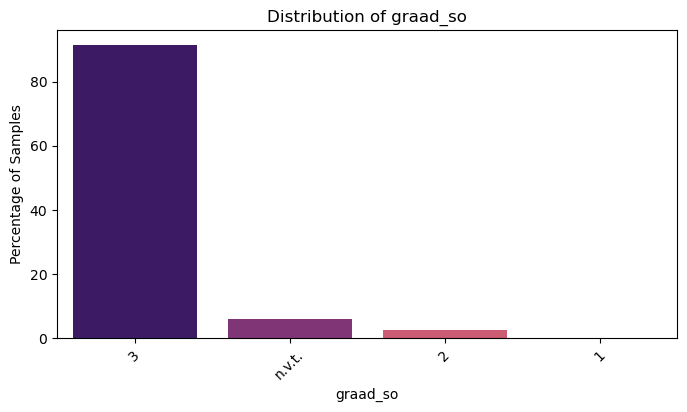


Feature Imbalance for hoofdstructuur:
hoofdstructuur
Voltijds gewoon secundair onderwijs     92.170843
Deeltijds beroepssecundair onderwijs     4.485963
Buitengewoon secundair onderwijs         2.778088
Syntra vlaanderen                        0.565106
Name: proportion, dtype: float64


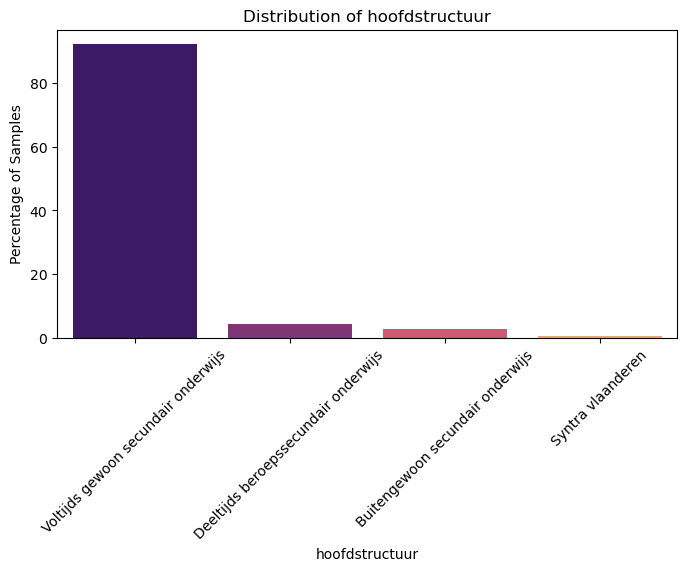


Feature Imbalance for leerjaar:
leerjaar
2    88.349054
1     5.610593
/     3.909695
5     1.604621
4     0.269297
Name: proportion, dtype: float64


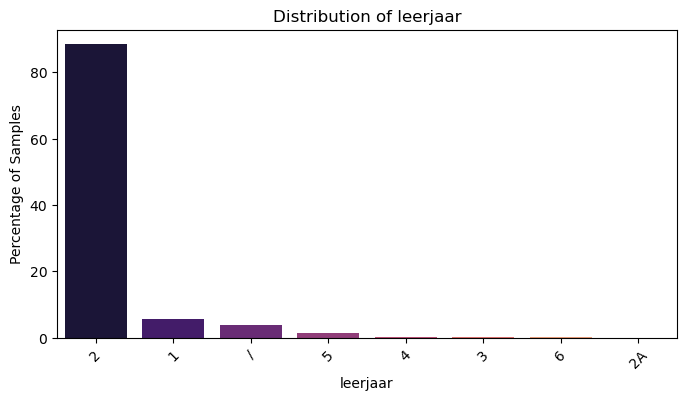


Feature Imbalance for studiegebied:
studiegebied
Algemeen secundair onderwijs    35.981191
Personenzorg                    14.310431
Handel                          11.565831
n.v.t. (modernisering SO)        8.483563
Mechanica-elektriciteit          7.513814
Name: proportion, dtype: float64


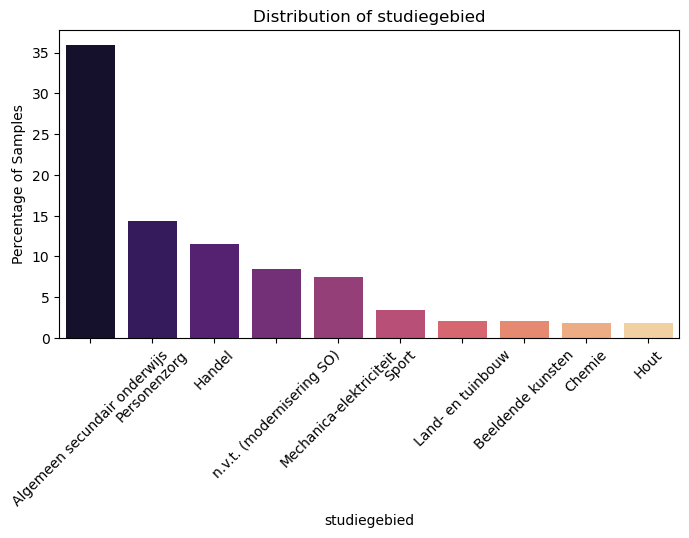


Feature Imbalance for woonplaats_fusiegemeente_nis:
woonplaats_fusiegemeente_nis
11002    7.981247
44021    3.650165
31005    1.618575
12025    1.359044
46021    1.340905
Name: proportion, dtype: float64


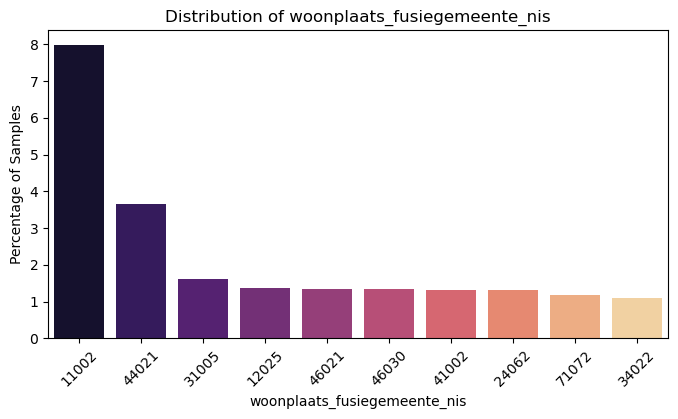


Feature Imbalance for woonplaats_fusiegemeente_naam:
woonplaats_fusiegemeente_naam
Antwerpen       7.981247
Gent            3.650165
Brugge          1.618575
Mechelen        1.359044
Sint-Niklaas    1.340905
Name: proportion, dtype: float64


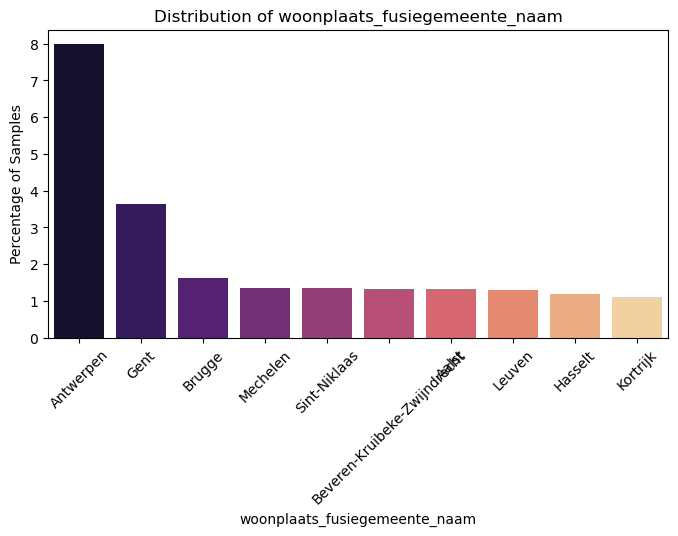


Feature Imbalance for woonplaats_fusiegemeente_naam_bhg:
woonplaats_fusiegemeente_naam_bhg
Overige (niet-centrumsteden)      70.840543
Antwerpen                          7.981247
Gent                               3.650165
Brussels Hoofdstedelijk Gewest     3.008316
Buitenland + Waals Gewest          1.709271
Name: proportion, dtype: float64


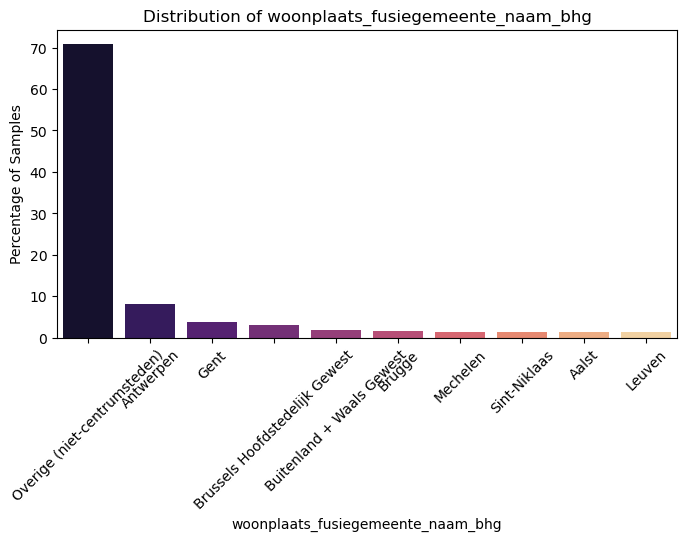


Feature Imbalance for woonplaats_provincie_naam:
woonplaats_provincie_naam
Antwerpen          27.306469
Oost-Vlaanderen    23.296311
West-Vlaanderen    16.791316
Vlaams-Brabant     15.365296
Limburg            12.523023
Name: proportion, dtype: float64


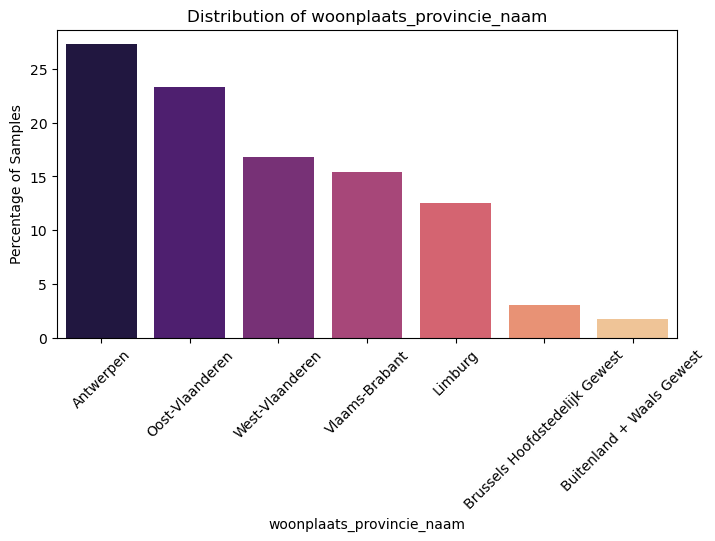


Feature Imbalance for woonplaats_gewest_naam:
woonplaats_gewest_naam
Vlaams Gewest                     95.282413
Brussels Hoofdstedelijk Gewest     3.008316
Buitenland + Waals Gewest          1.709271
Name: proportion, dtype: float64


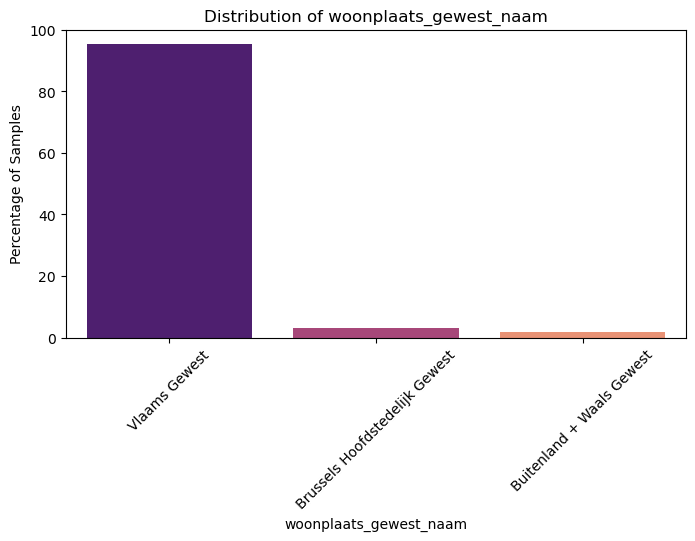


Feature Imbalance for woonplaats_centrumstad:
woonplaats_centrumstad
Nee    75.558129
Ja     24.441871
Name: proportion, dtype: float64


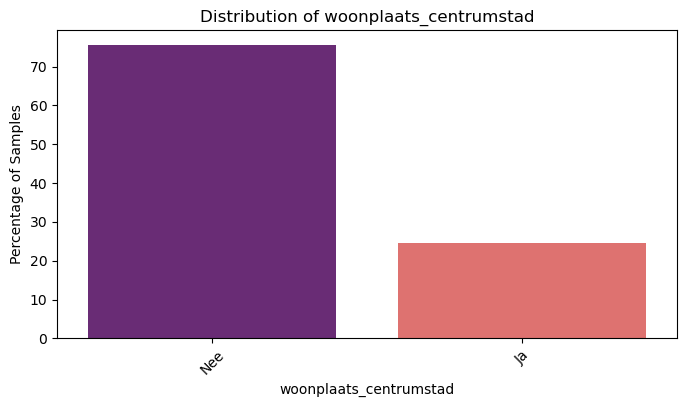


Feature Imbalance for woonplaats_centrumstad_bhg:
woonplaats_centrumstad_bhg
Nee    72.549813
Ja     27.450187
Name: proportion, dtype: float64


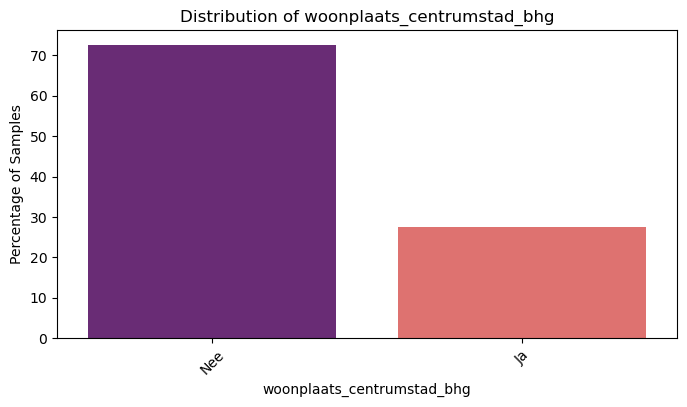


Feature Imbalance for woonplaats_vlaamse_rand:
woonplaats_vlaamse_rand
Nee    95.250321
Ja      4.749679
Name: proportion, dtype: float64


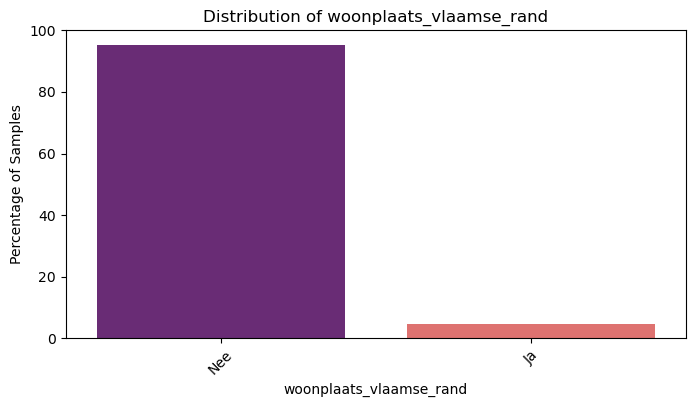


Feature Imbalance for woonplaats_land_naam:
woonplaats_land_naam
België                         99.193503
Nederland                       0.798125
Frankrijk                       0.006977
Luxemburg (Groot-Hertogdom)     0.001395
Name: proportion, dtype: float64


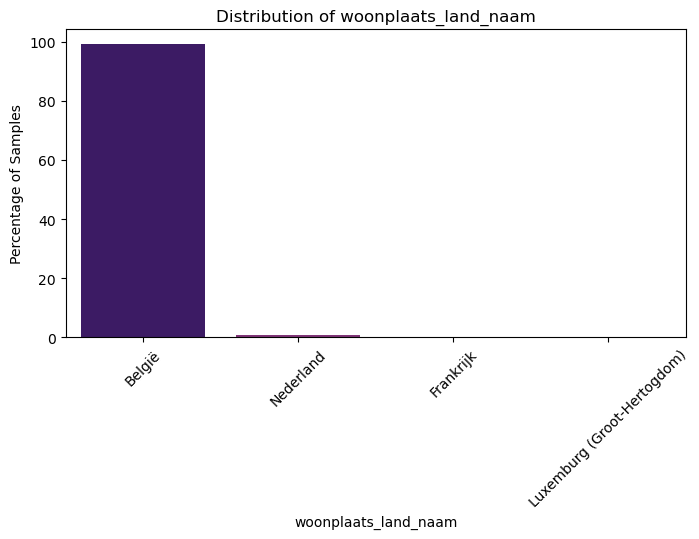

In [9]:
# Select categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Check unique value distribution for each categorical feature
for col in categorical_cols:
    value_counts = df[col].value_counts(normalize=True) * 100
    print(f"\nFeature Imbalance for {col}:")
    print(value_counts.head(5))  # Display top 5 categories

    # Plot distribution
    plt.figure(figsize=(8, 4))
    sns.barplot(x=value_counts.index[:10], y=value_counts.values[:10], hue=value_counts.index[:10], palette="magma", legend=False)  # Show top 10 values
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel("Percentage of Samples")
    plt.title(f"Distribution of {col}")
    plt.show()

<h3>Spatial imbalance</h3>

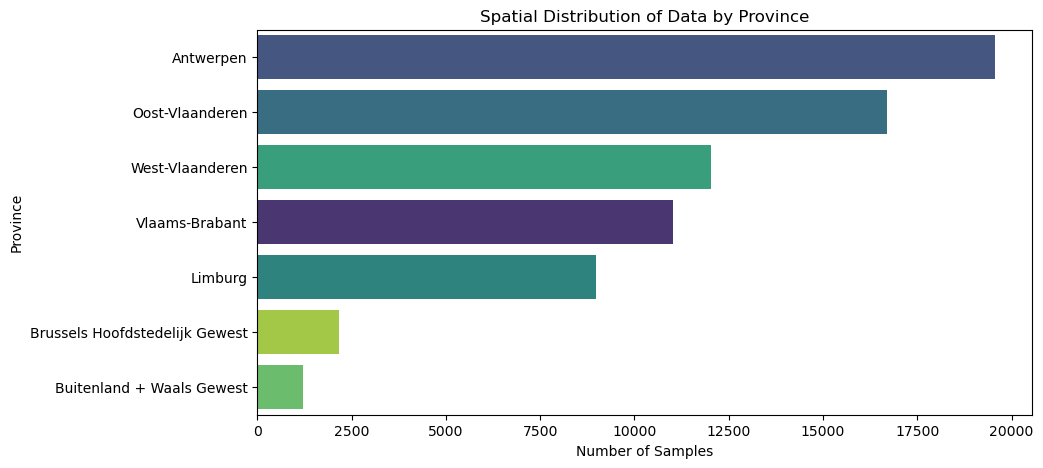

In [10]:
# Check spatial imbalance (e.g., province, city)
if 'woonplaats_provincie_naam' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, y='woonplaats_provincie_naam', order=df['woonplaats_provincie_naam'].value_counts().index, hue='woonplaats_provincie_naam', palette="viridis", legend=False)
    plt.xlabel("Number of Samples")
    plt.ylabel("Province")
    plt.title("Spatial Distribution of Data by Province")
    plt.show()


<h3>Mitigating imbalances</h3>

Before Resampling:
vsv_teller
0    0.868141
1    0.131859
Name: proportion, dtype: float64
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     12444
           1       0.81      0.75      0.78      1890

    accuracy                           0.94     14334
   macro avg       0.88      0.86      0.87     14334
weighted avg       0.94      0.94      0.94     14334

ROC-AUC Score: 0.9361


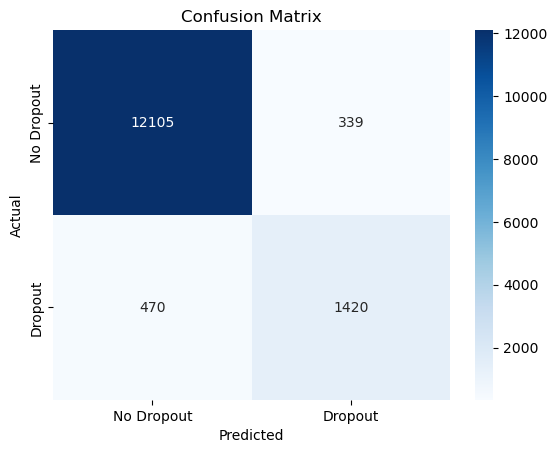

In [18]:
X = df.drop(columns=['vsv_teller'])
y = df['vsv_teller']

# Categorical preprocessing
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['number']).columns

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_cols)
], remainder='passthrough')

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Check class distribution before resampling
print("Before Resampling:")
print(y_train.value_counts(normalize=True))

# Resampling strategy
over = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.8, random_state=42)

# Build full pipeline
resampling_pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('over', over),
    ('under', under),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Fit model
resampling_pipeline.fit(X_train, y_train)

# Predict
y_pred = resampling_pipeline.predict(X_test)
y_proba = resampling_pipeline.predict_proba(X_test)[:, 1]

# Evaluation
def evaluate_model(y_true, y_pred, y_proba):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    auc = roc_auc_score(y_true, y_proba)
    print(f"ROC-AUC Score: {auc:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Dropout", "Dropout"],
                yticklabels=["No Dropout", "Dropout"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(y_test, y_pred, y_proba)

<h1>Analyze data distribution</h1>

Numerical Feature Distribution Analysis:

Feature: vsv_teller
count    71668.000000
mean         0.131858
std          0.338339
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: vsv_teller, dtype: float64
Skewness: 2.18


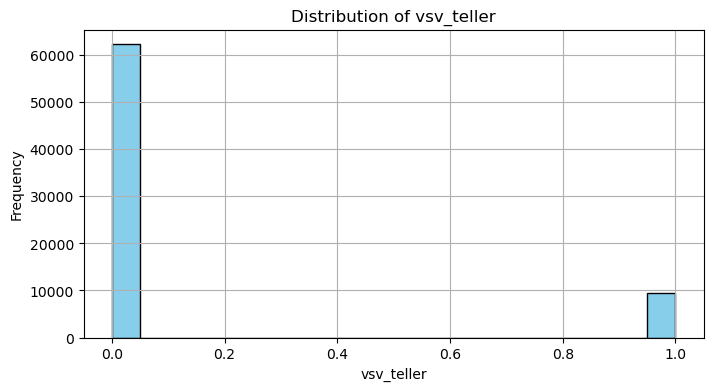

Highly skewed distribution – may affect model performance.

🧩 Categorical Feature Distribution Analysis:

Feature: oki_waarde
oki_waarde
0                   31387
1                   18289
3,4                 10054
2                    9752
Niet beschikbaar     2186
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


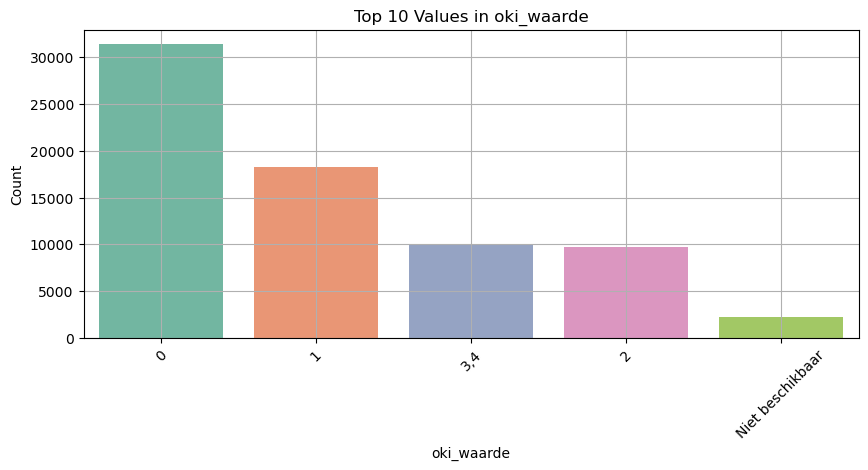


Feature: risicokenmerk_buurt
risicokenmerk_buurt
Nee                 52828
Ja                  16653
Niet beschikbaar     2187
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


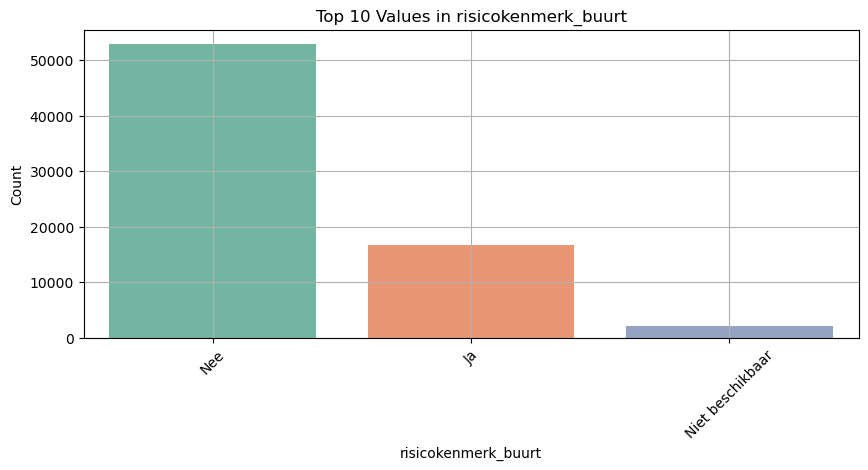


Feature: risicokenmerk_thuis_taal
risicokenmerk_thuis_taal
Nee                 56348
Ja                  13134
Niet beschikbaar     2186
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


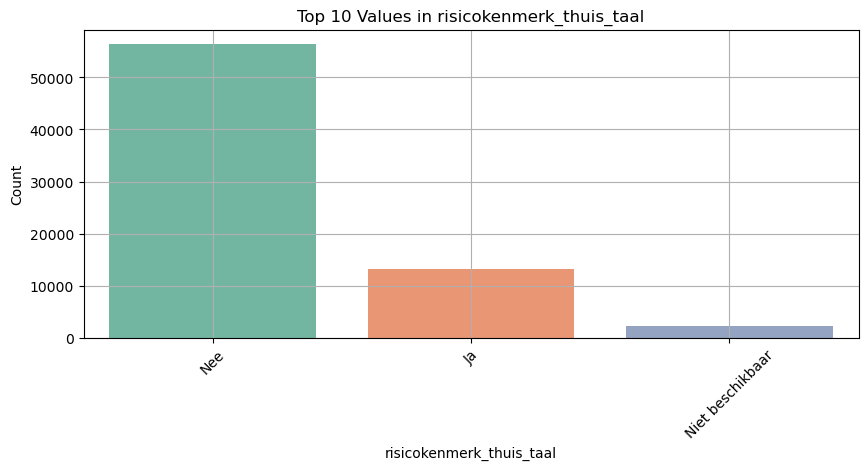


Feature: risicokenmerk_opleiding_moeder
risicokenmerk_opleiding_moeder
Nee                 54309
Ja                  15173
Niet beschikbaar     2186
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


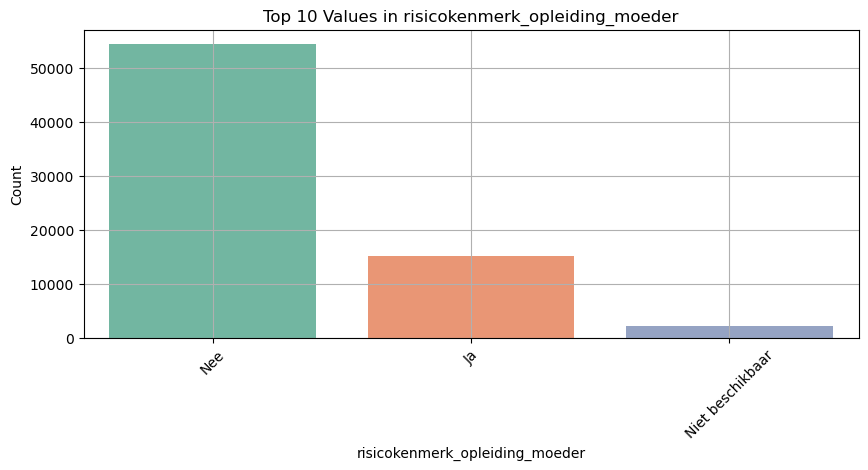

C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")



Feature: risicokenmerk_schooltoelage
risicokenmerk_schooltoelage
Nee                 43006
Ja                  26476
Niet beschikbaar     2186
Name: count, dtype: int64


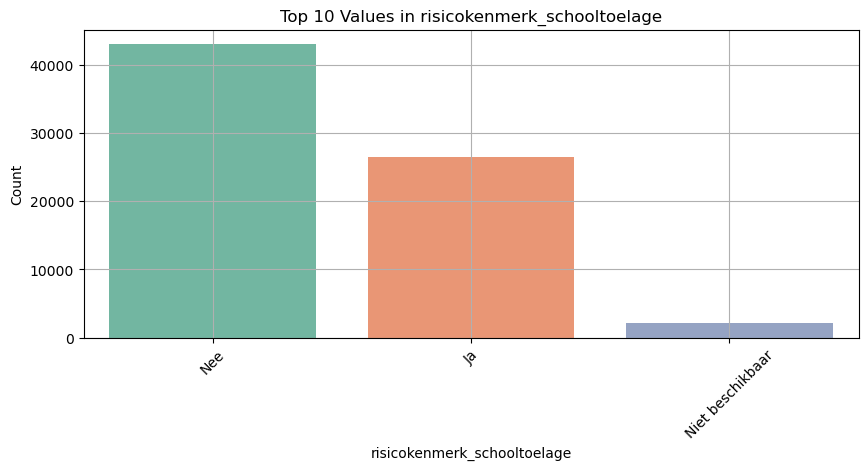


Feature: graad_leerjaar_secundair
graad_leerjaar_secundair
3e graad - 2e leerjaar    61979
n.v.t.                     4303
3e graad - 1e leerjaar     3544
2e graad - 2e leerjaar     1333
2e graad - 1e leerjaar      477
3e graad - 3e leerjaar       32
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


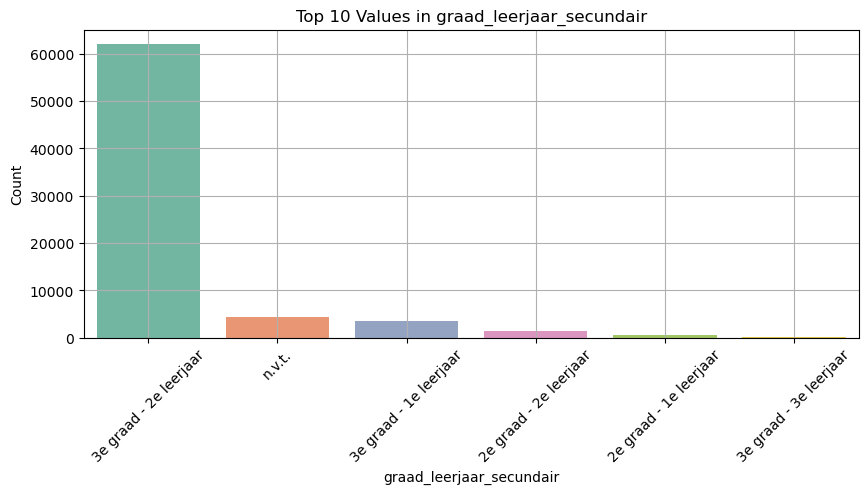


Feature: uitstroompositie
uitstroompositie
aso         26543
tso         22026
bso         15590
dbso         3215
kso          1897
buso OV3     1560
buso OV4      431
Syntra        405
1e graad        1
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


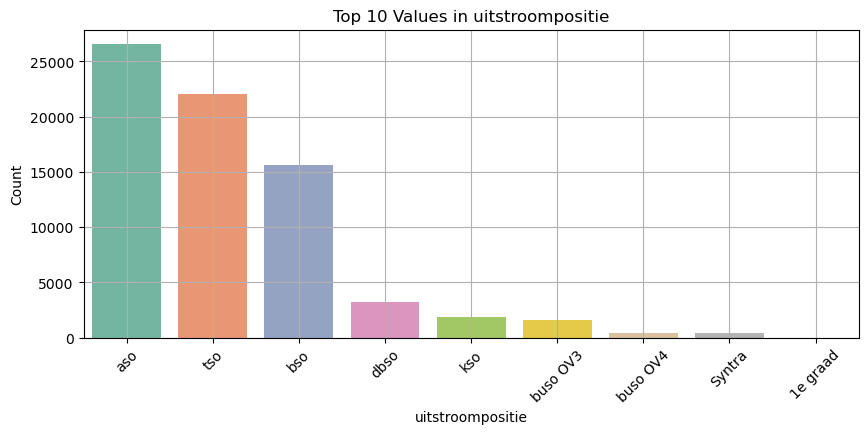


Feature: geslacht
geslacht
Mannelijk     36865
Vrouwelijk    34803
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


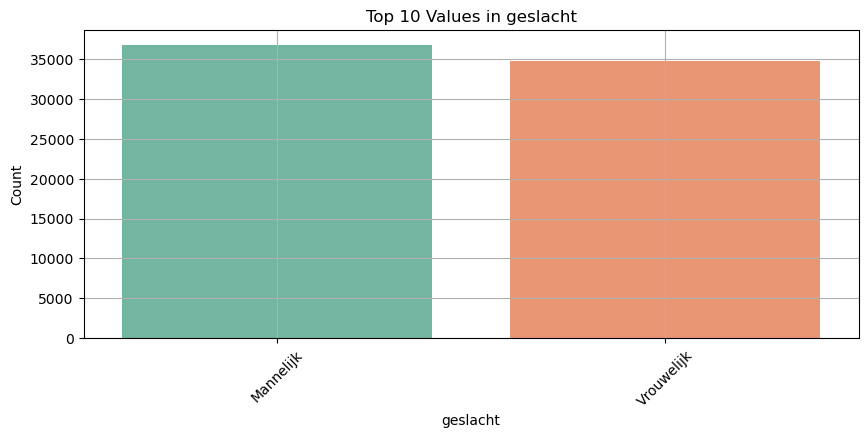


Feature: belg_nietbelg
belg_nietbelg
Belg         65296
niet-Belg     6372
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


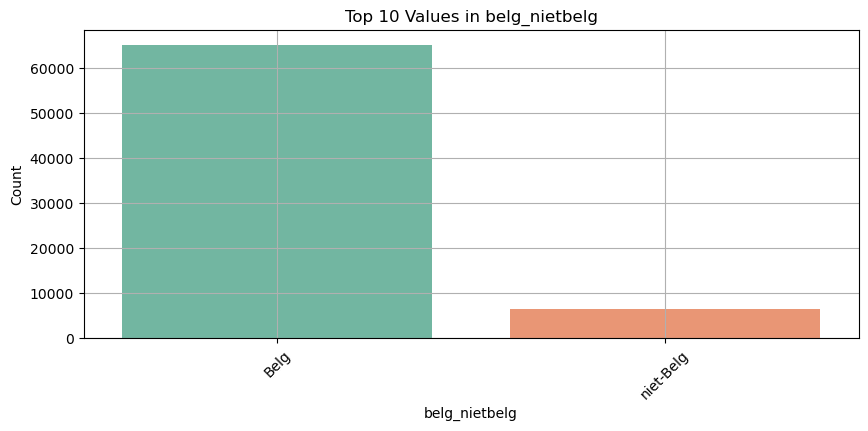

⚠️  Dominant category – risk of model bias towards this class.

Feature: eu_nieteu
eu_nieteu
EU         69013
niet-EU     2655
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


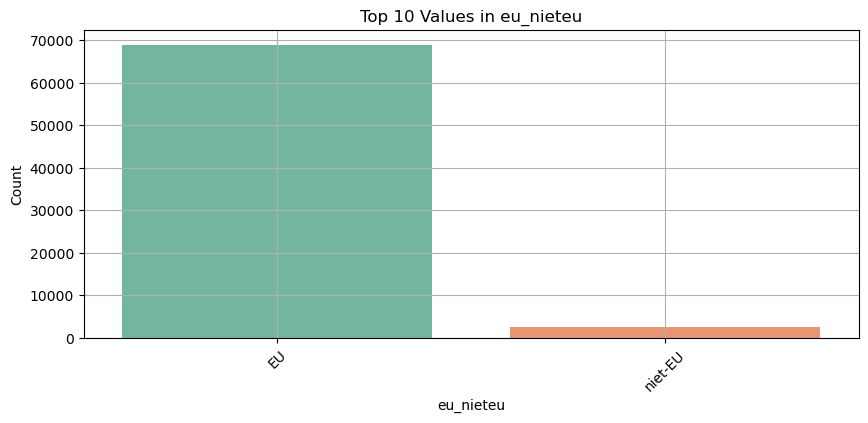

⚠️  Dominant category – risk of model bias towards this class.

Feature: leeftijdscategorie
leeftijdscategorie
17-18     49406
18-19     16148
19-20      3691
<17-18     1328
20-21       862
21-22       161
>21-22       72
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


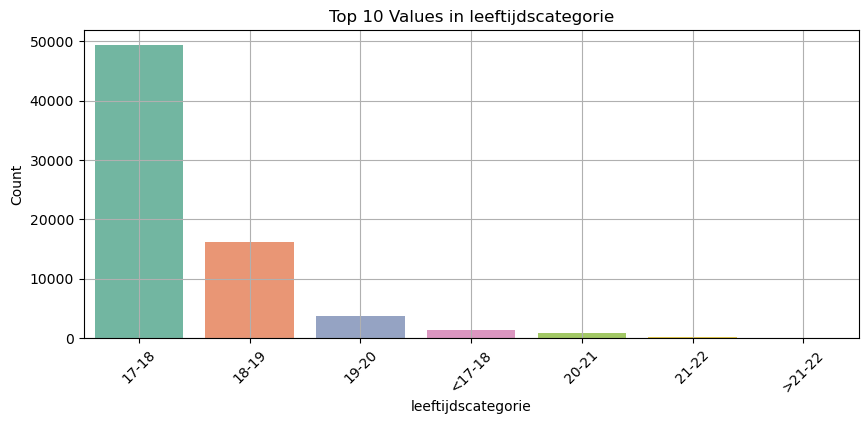


Feature: type_loopbanen_so
type_loopbanen_so
1A-2A-4ASO-EASO    25950
1A-2A-4TSO-ETSO    16726
Andere              9246
1B-2B-4BSO-EBSO     6277
1A-2A-4ASO-ETSO     4410
1A-2A-4BSO-EBSO     3405
1A-2A-4TSO-EBSO     2331
1A-2B-4BSO-EBSO     2053
1A-2A-4KSO-EKSO     1270
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


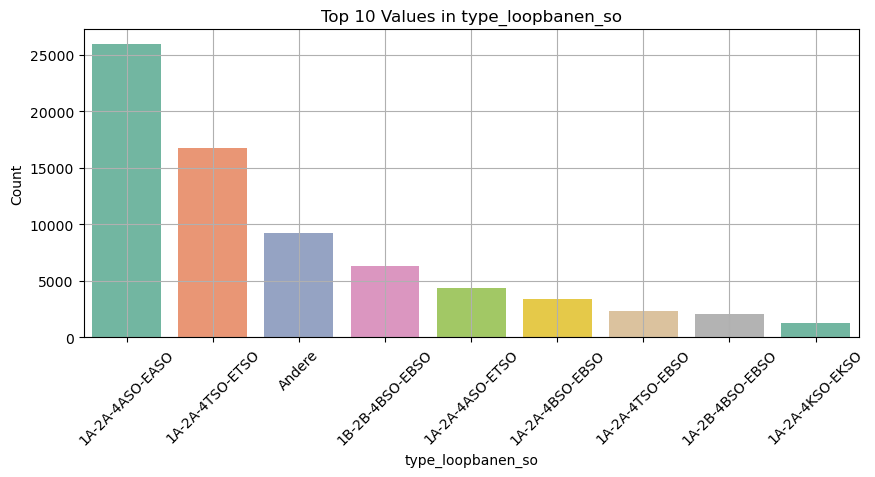


Feature: gezinstaal_nederlands
gezinstaal_nederlands
Uitsluitend Ned met allen    49438
Ned met minstens 1           10527
Ned met niemand               9321
n.v.t.                        2164
Onbekend                       218
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


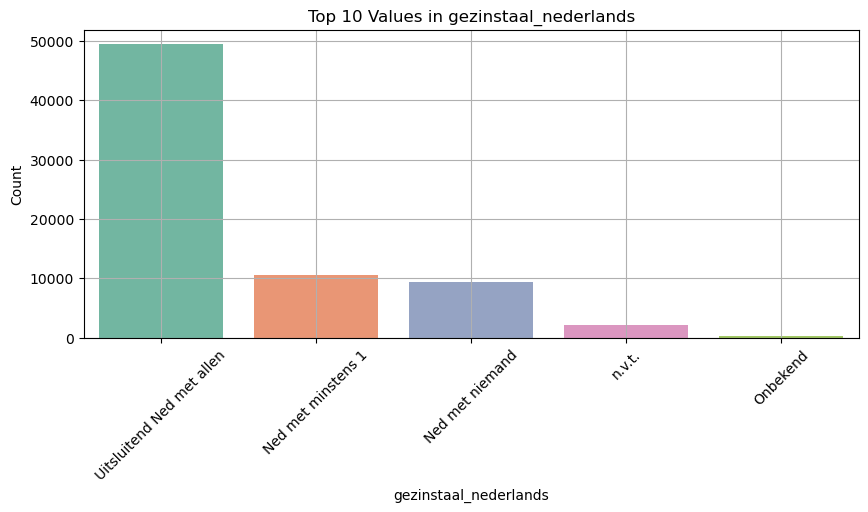


Feature: opleidingsniveau_moeder
opleidingsniveau_moeder
Hoger onderwijs              30496
Hoger secundair onderwijs    23198
Lager secundair onderwijs     8413
Lager onderwijs               3766
Geen lager onderwijs          2994
n.v.t.                        2164
Onbekend                       637
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


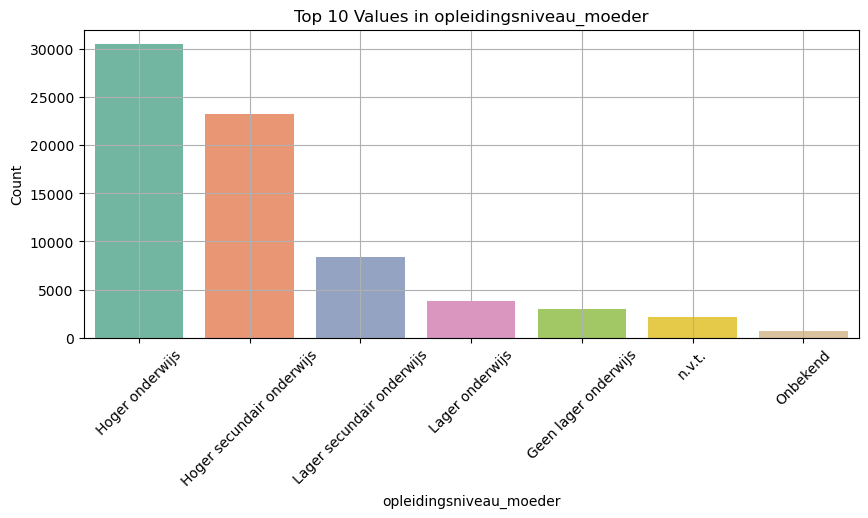


Feature: schoolse_vordering
schoolse_vordering
Geen schoolse achterstand               44768
1 jaar schoolse achterstand             16000
2 jaar schoolse achterstand              5022
n.v.t.                                   4422
Meer dan 2 jaar schoolse achterstand     1456
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


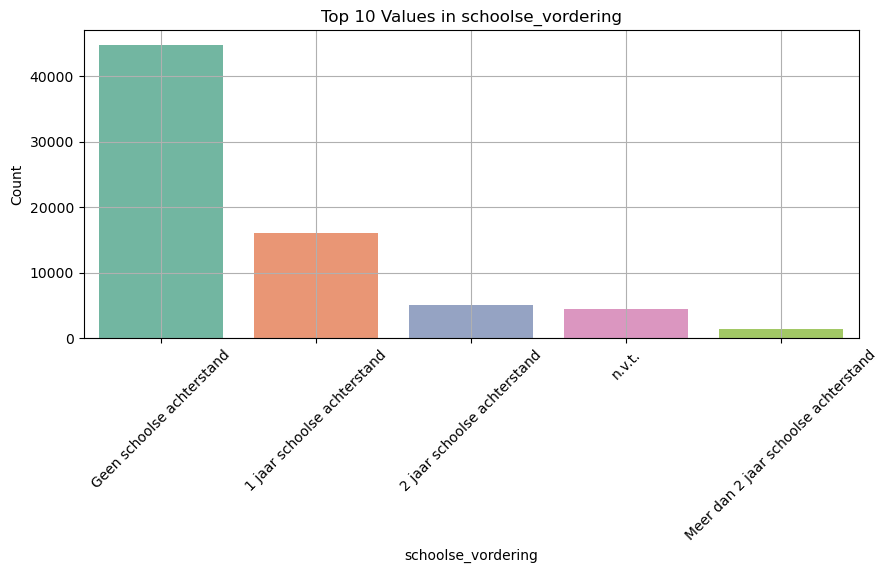


Feature: graad_so
graad_so
3         65555
n.v.t.     4302
2          1810
1             1
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


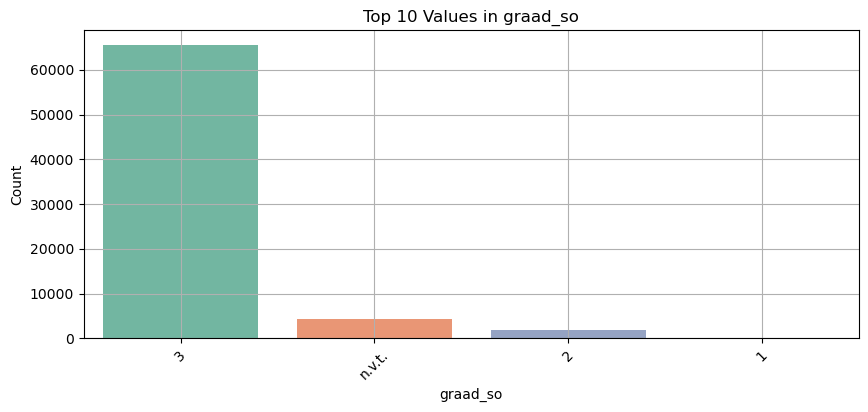

⚠️  Dominant category – risk of model bias towards this class.

Feature: hoofdstructuur
hoofdstructuur
Voltijds gewoon secundair onderwijs     66057
Deeltijds beroepssecundair onderwijs     3215
Buitengewoon secundair onderwijs         1991
Syntra vlaanderen                         405
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


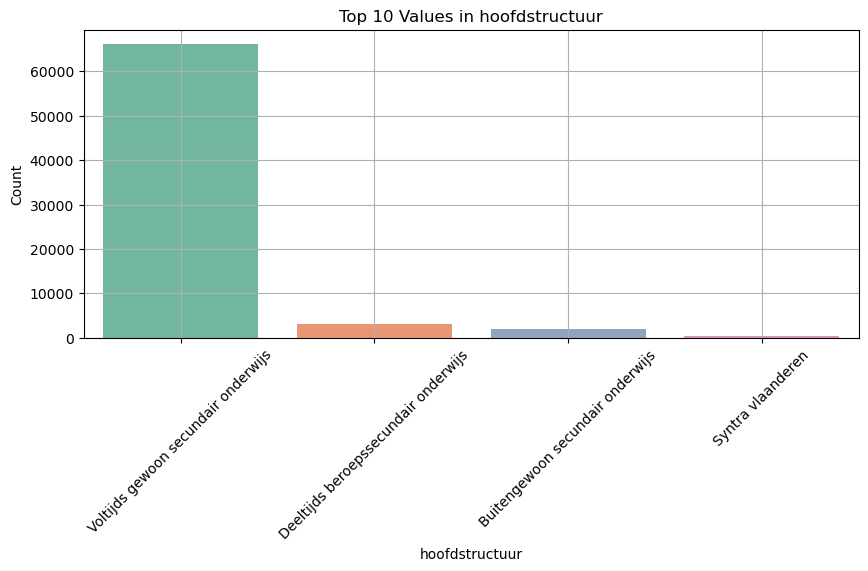

⚠️  Dominant category – risk of model bias towards this class.

Feature: leerjaar
leerjaar
2     63318
1      4021
/      2802
5      1150
4       193
3        94
6        89
2A        1
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


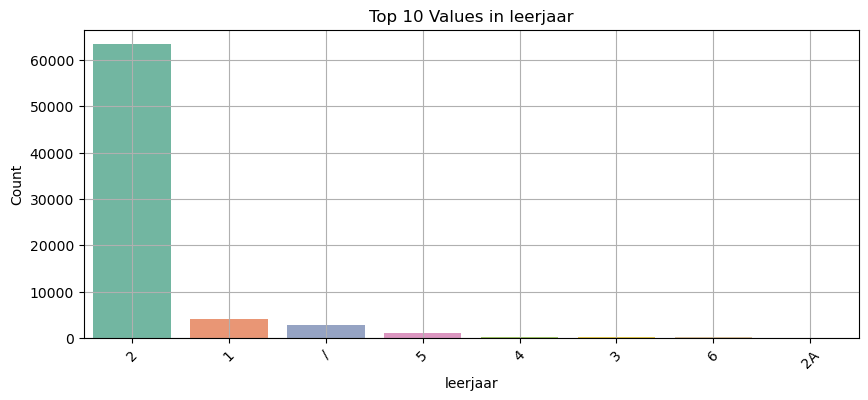


Feature: studiegebied
studiegebied
Algemeen secundair onderwijs    25787
Personenzorg                    10256
Handel                           8289
n.v.t. (modernisering SO)        6080
Mechanica-elektriciteit          5385
Sport                            2420
Land- en tuinbouw                1502
Beeldende kunsten                1481
Chemie                           1333
Hout                             1333
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


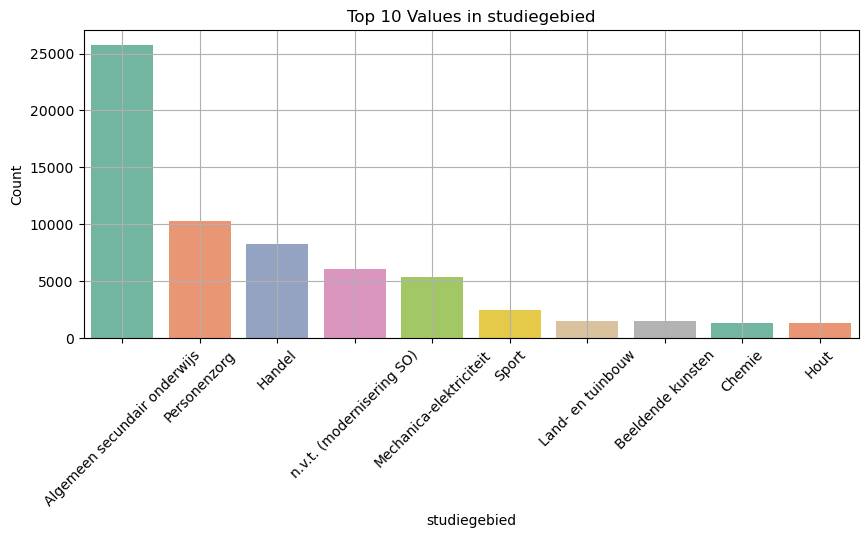

ℹ️  High cardinality – consider grouping or dimensionality reduction.

Feature: woonplaats_fusiegemeente_nis
woonplaats_fusiegemeente_nis
11002    5720
44021    2616
31005    1160
12025     974
46021     961
46030     952
41002     943
24062     939
71072     852
34022     788
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


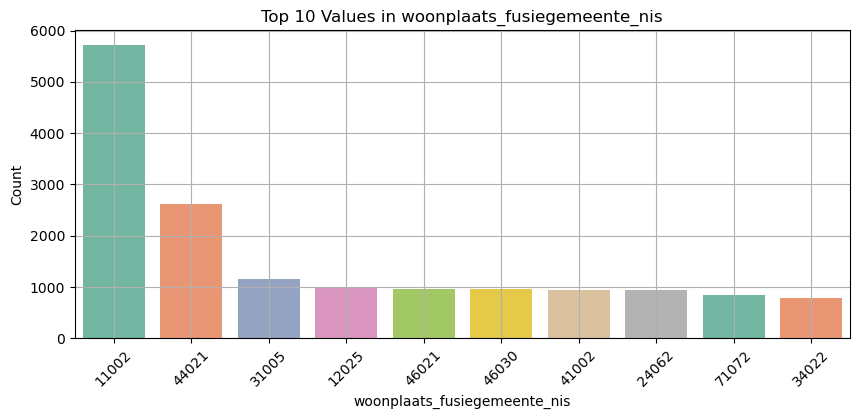

ℹ️  High cardinality – consider grouping or dimensionality reduction.

Feature: woonplaats_fusiegemeente_naam
woonplaats_fusiegemeente_naam
Antwerpen                       5720
Gent                            2616
Brugge                          1160
Mechelen                         974
Sint-Niklaas                     961
Beveren-Kruibeke-Zwijndrecht     952
Aalst                            943
Leuven                           939
Hasselt                          852
Kortrijk                         788
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


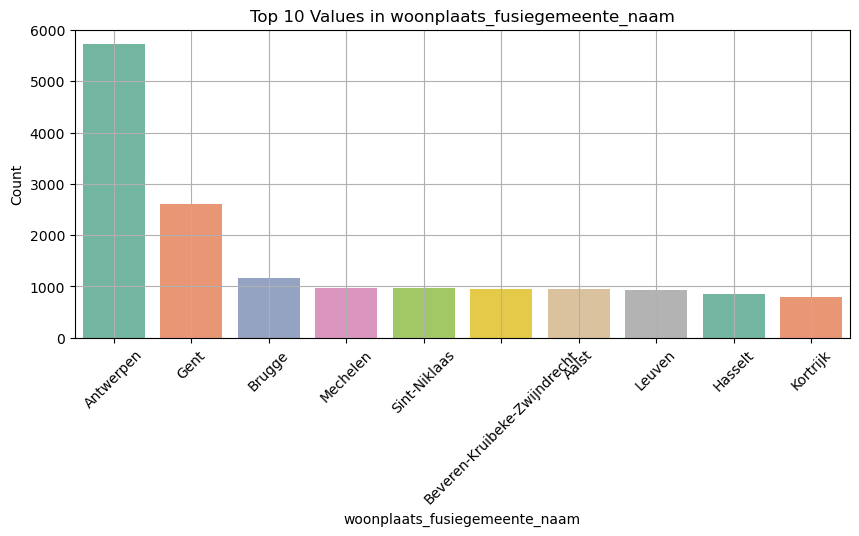

ℹ️  High cardinality – consider grouping or dimensionality reduction.

Feature: woonplaats_fusiegemeente_naam_bhg
woonplaats_fusiegemeente_naam_bhg
Overige (niet-centrumsteden)      50770
Antwerpen                          5720
Gent                               2616
Brussels Hoofdstedelijk Gewest     2156
Buitenland + Waals Gewest          1225
Brugge                             1160
Mechelen                            974
Sint-Niklaas                        961
Aalst                               943
Leuven                              939
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


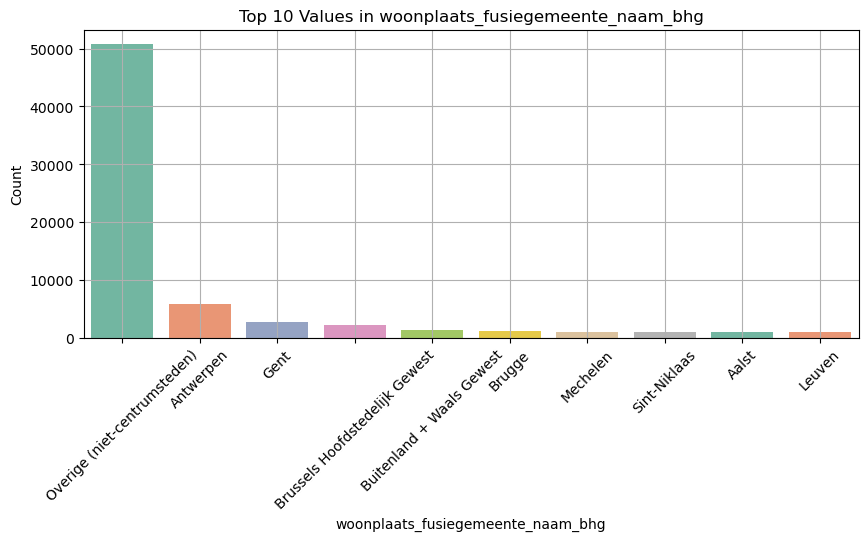


Feature: woonplaats_provincie_naam
woonplaats_provincie_naam
Antwerpen                         19570
Oost-Vlaanderen                   16696
West-Vlaanderen                   12034
Vlaams-Brabant                    11012
Limburg                            8975
Brussels Hoofdstedelijk Gewest     2156
Buitenland + Waals Gewest          1225
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


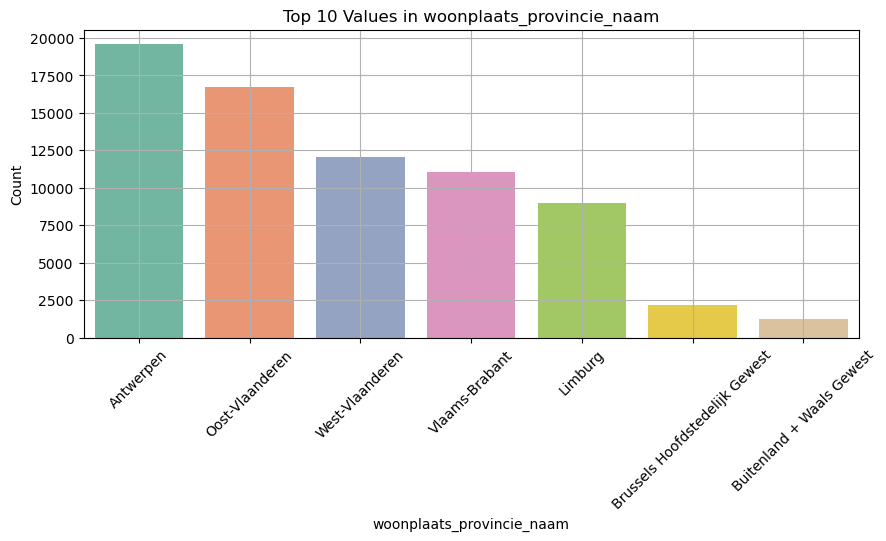


Feature: woonplaats_gewest_naam
woonplaats_gewest_naam
Vlaams Gewest                     68287
Brussels Hoofdstedelijk Gewest     2156
Buitenland + Waals Gewest          1225
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


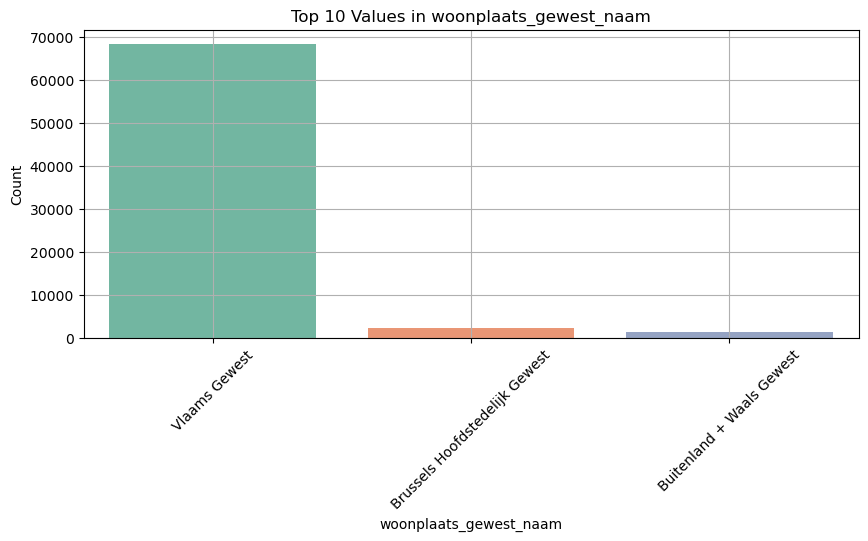

⚠️  Dominant category – risk of model bias towards this class.

Feature: woonplaats_centrumstad
woonplaats_centrumstad
Nee    54151
Ja     17517
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


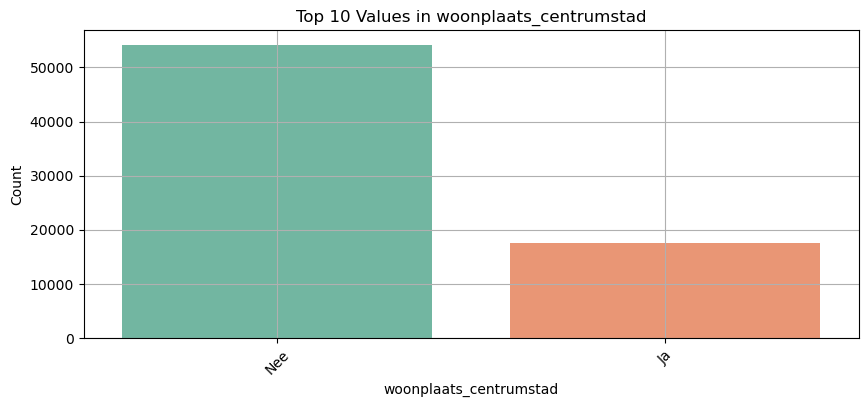


Feature: woonplaats_centrumstad_bhg
woonplaats_centrumstad_bhg
Nee    51995
Ja     19673
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


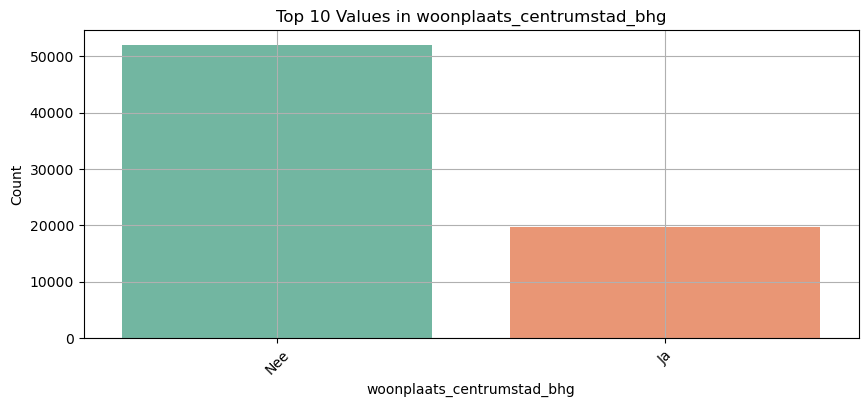

C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")



Feature: woonplaats_vlaamse_rand
woonplaats_vlaamse_rand
Nee    68264
Ja      3404
Name: count, dtype: int64


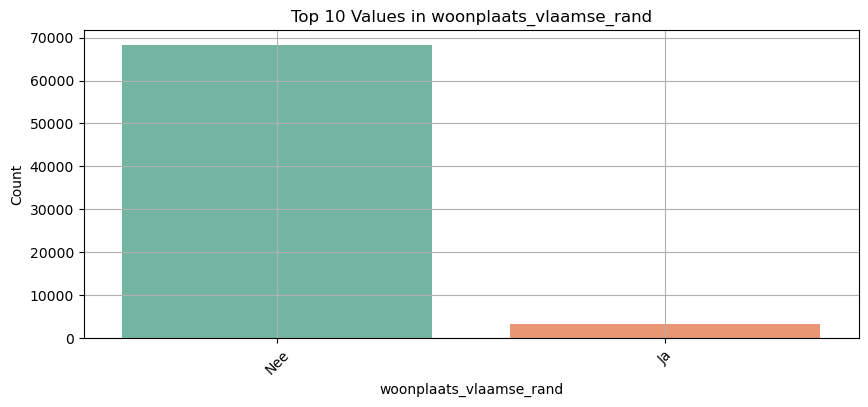

⚠️  Dominant category – risk of model bias towards this class.

Feature: woonplaats_land_naam
woonplaats_land_naam
België                         71090
Nederland                        572
Frankrijk                          5
Luxemburg (Groot-Hertogdom)        1
Name: count, dtype: int64


C:\Users\mouni\AppData\Local\Temp\ipykernel_19132\2521875318.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")


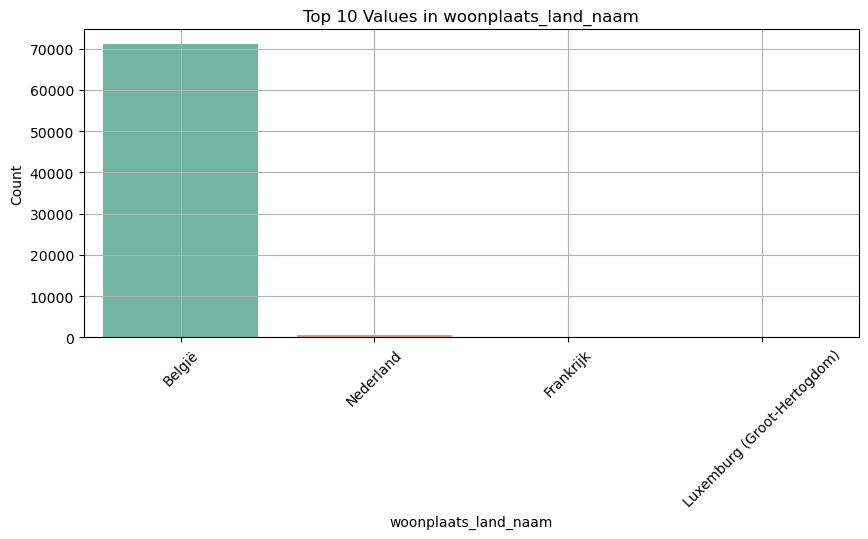

⚠️  Dominant category – risk of model bias towards this class.


In [19]:
# Analyze distribution of all features
def analyze_feature_distributions(df):
    num_cols = df.select_dtypes(include=['number']).columns
    cat_cols = df.select_dtypes(include=['object']).columns

    print("Numerical Feature Distribution Analysis:")
    for col in num_cols:
        print(f"\nFeature: {col}")
        desc = df[col].describe()
        print(desc)
        skewness = df[col].skew()
        print(f"Skewness: {skewness:.2f}")
        
        # Histogram
        plt.figure(figsize=(8, 4))
        plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()
        
        if skewness > 1 or skewness < -1:
            print("Highly skewed distribution – may affect model performance.")
        if desc['min'] == desc['max']:
            print("Constant feature – no variability.")
    
    print("\n Categorical Feature Distribution Analysis:")
    for col in cat_cols:
        print(f"\nFeature: {col}")
        counts = df[col].value_counts()
        print(counts.head(10))  # Top categories

        # Bar plot
        plt.figure(figsize=(10, 4))
        sns.barplot(x=counts.index[:10], y=counts.values[:10], palette="Set2")
        plt.xticks(rotation=45)
        plt.title(f"Top 10 Values in {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.grid(True)
        plt.show()
        
        if counts.iloc[0] / counts.sum() > 0.9:
            print(" Dominant category – risk of model bias towards this class.")
        elif len(counts) > 20:
            print(" High cardinality – consider grouping or dimensionality reduction.")

# Run the analysis
analyze_feature_distributions(df)


<h1>relations between variables</h1>

🔎 Distributions per Target Class:


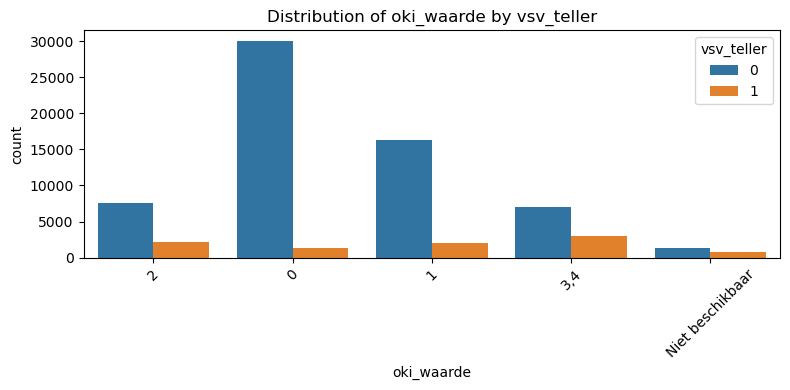

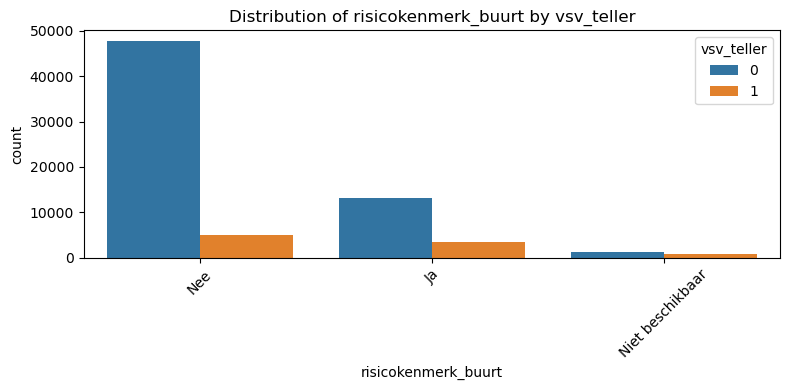

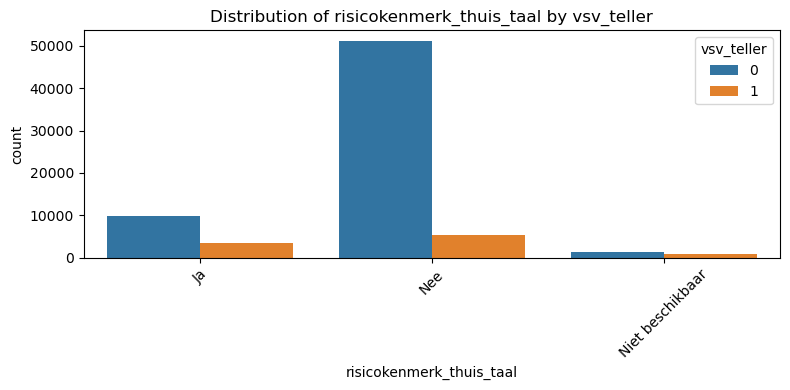

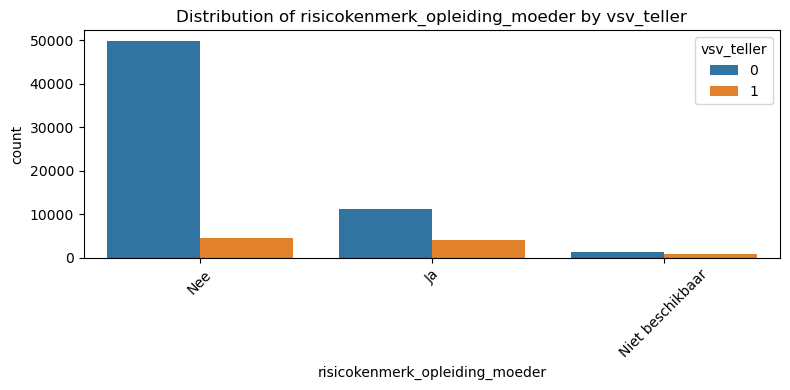

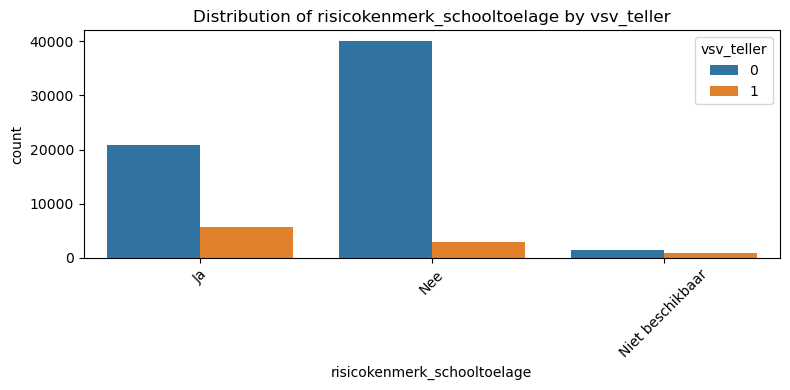

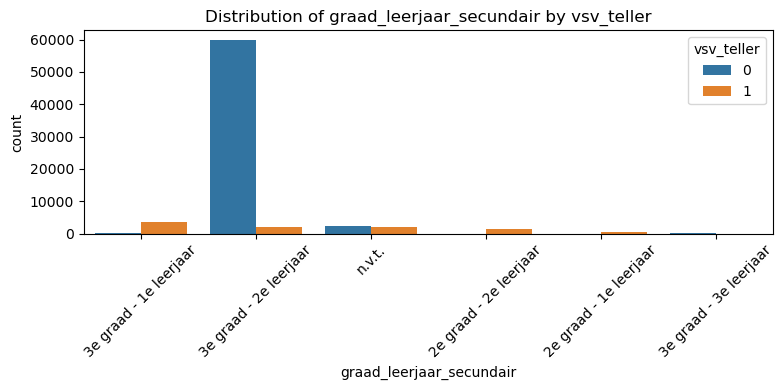

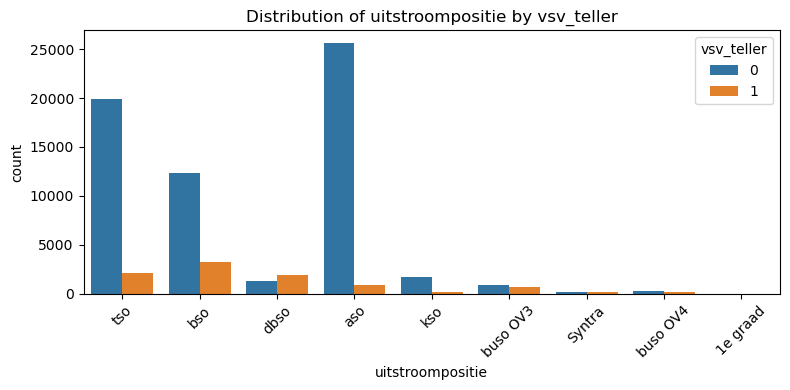

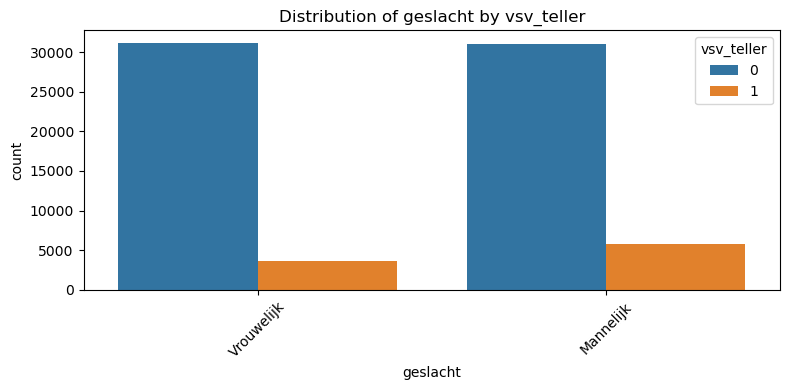

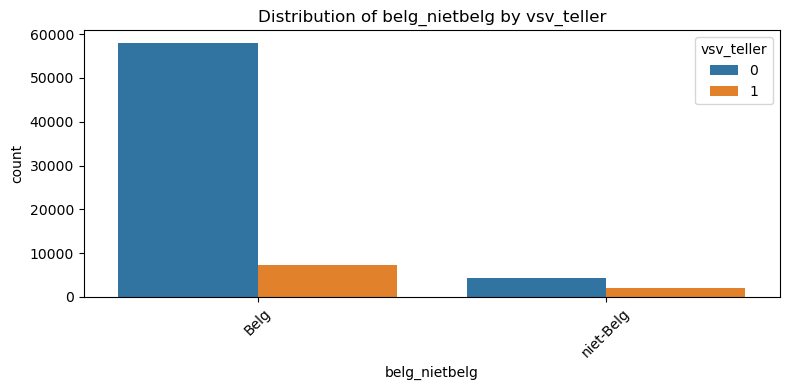

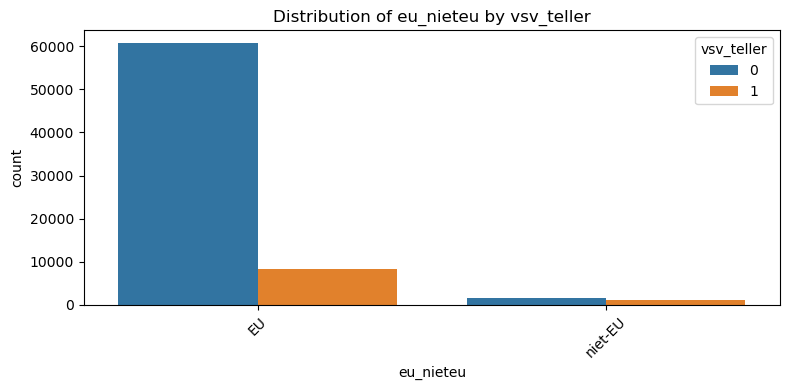

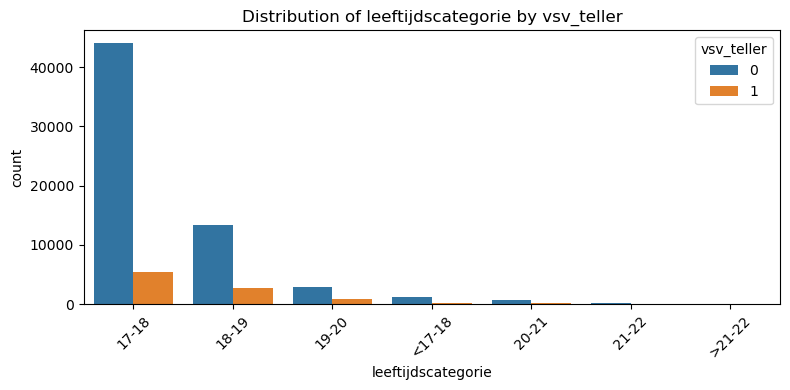

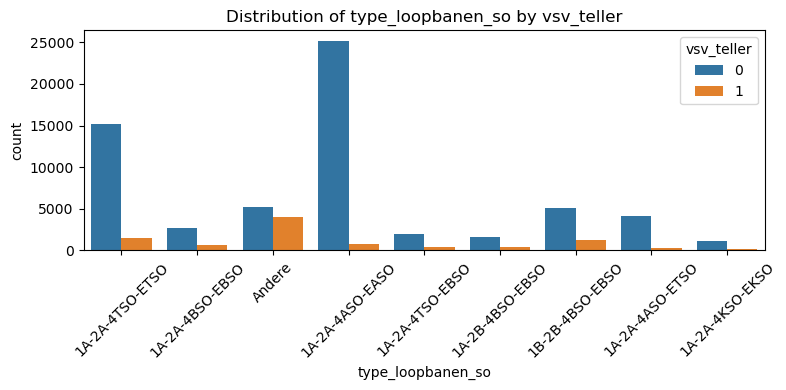

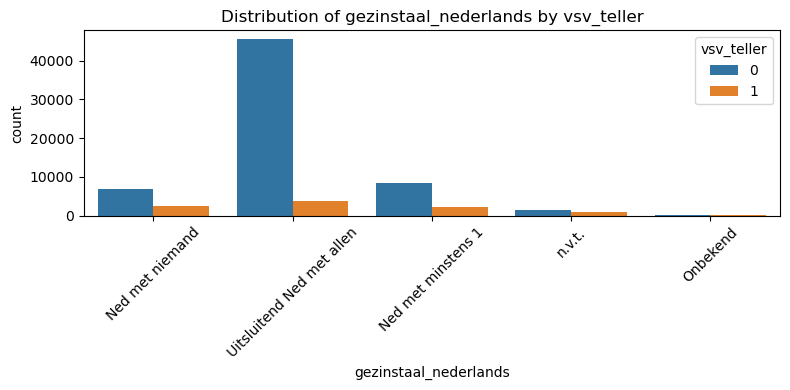

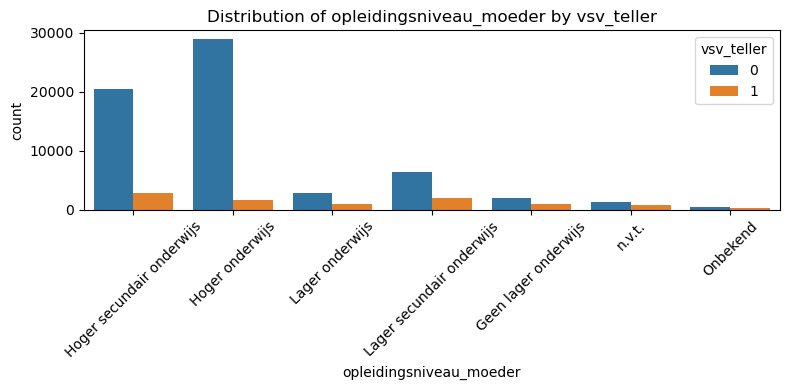

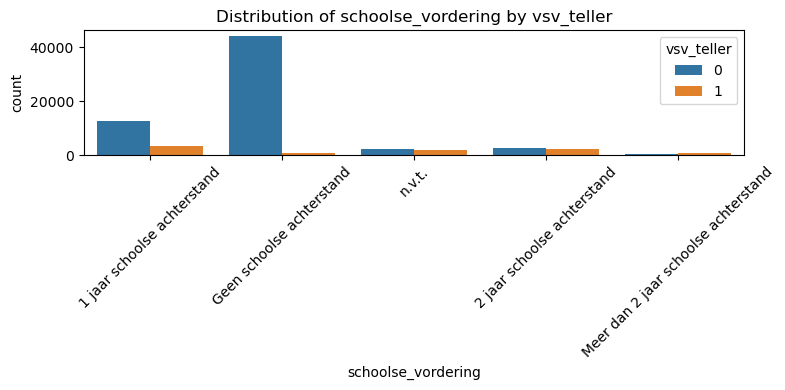

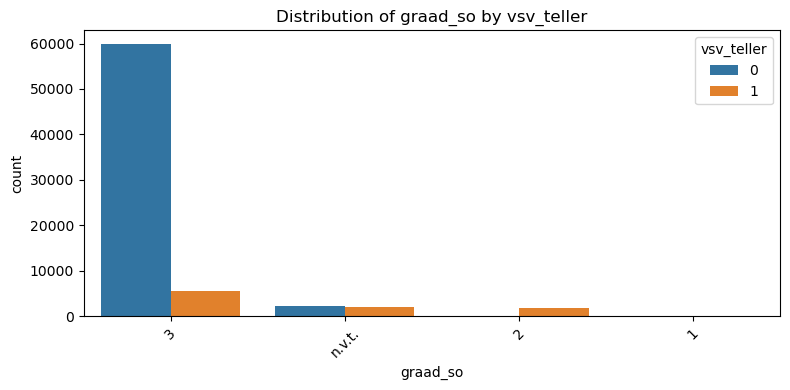

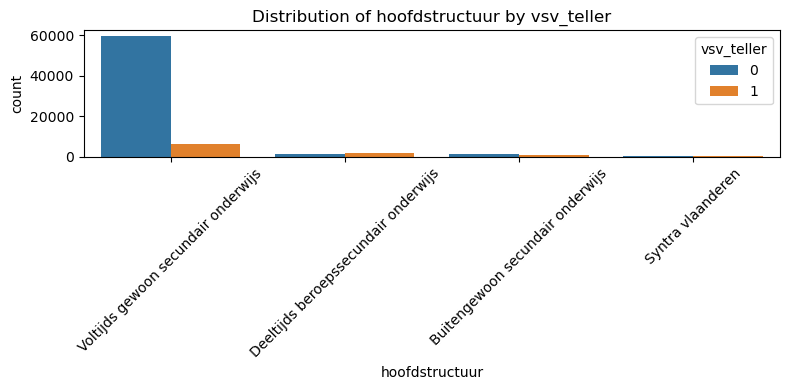

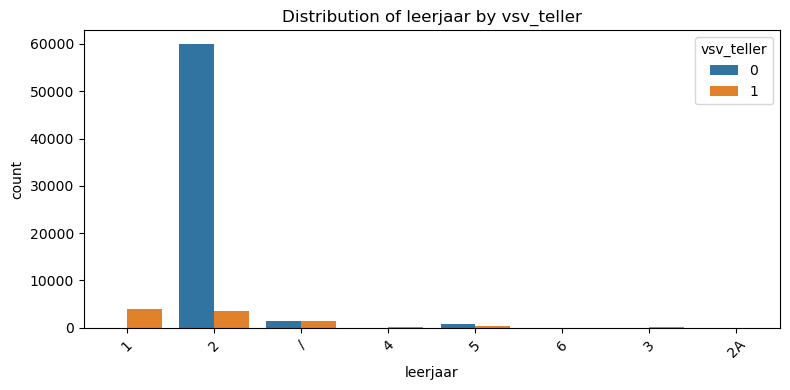

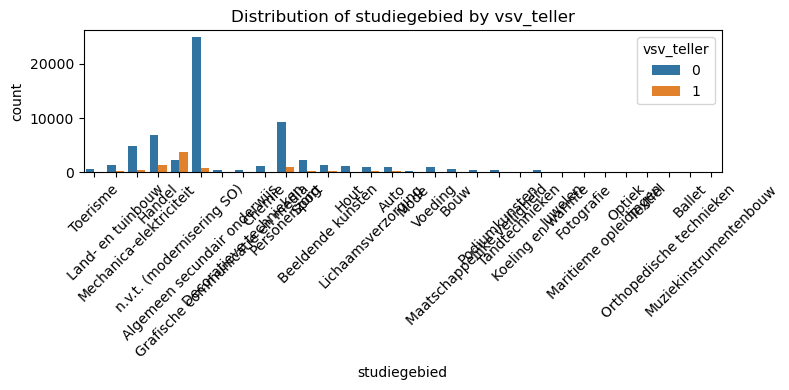

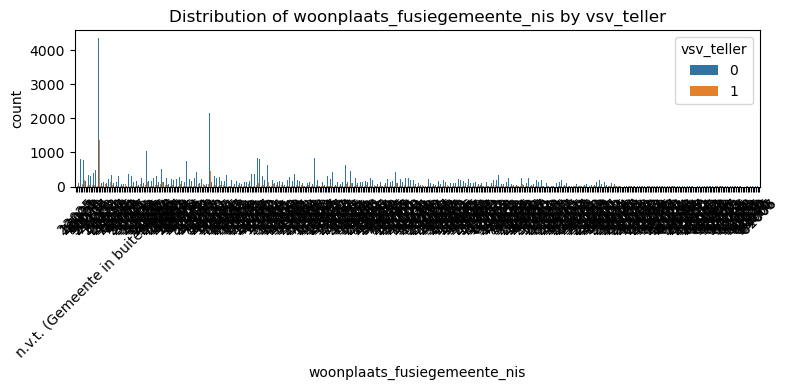

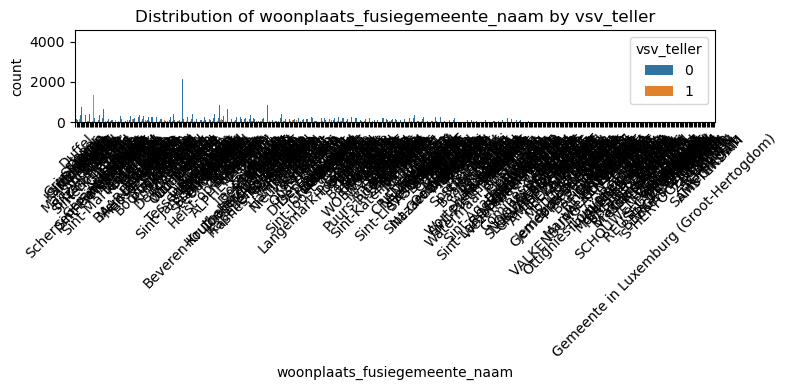

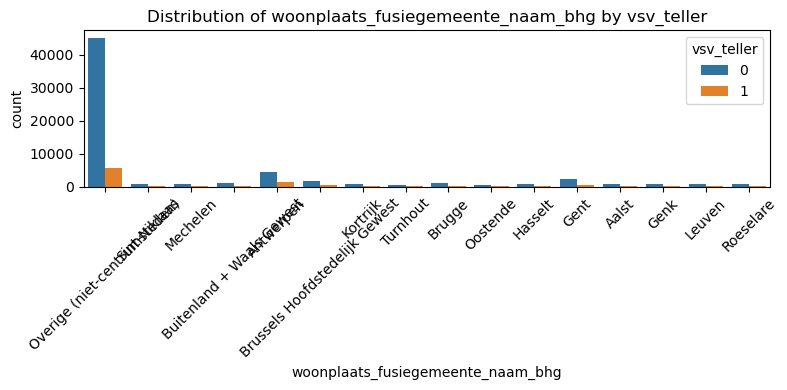

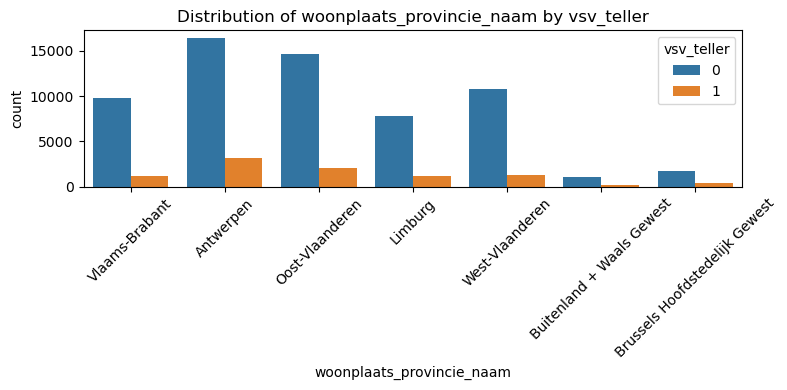

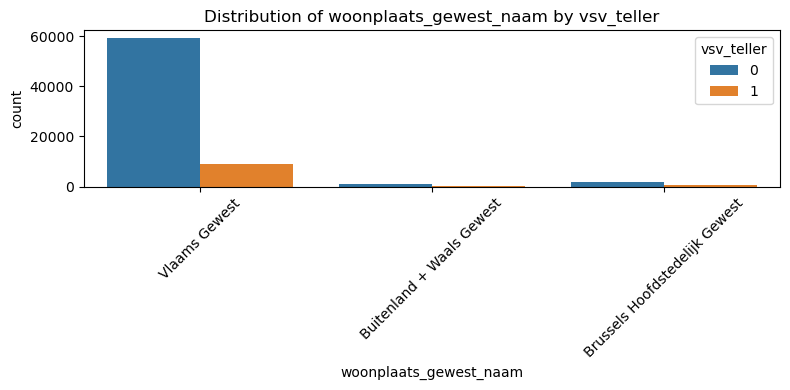

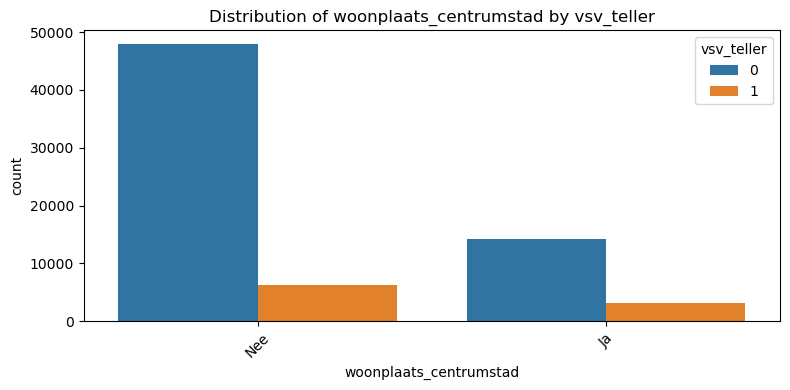

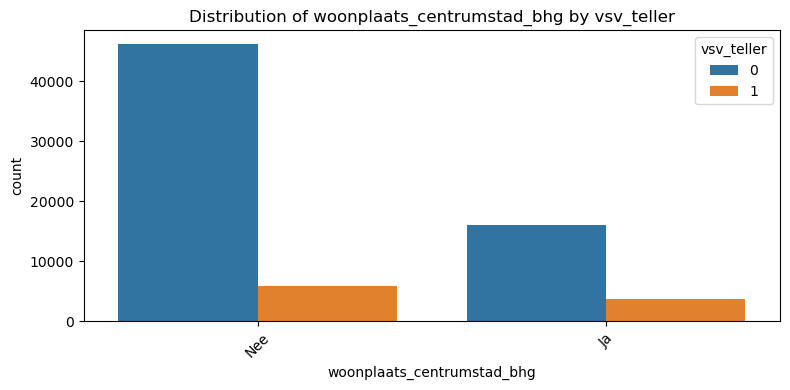

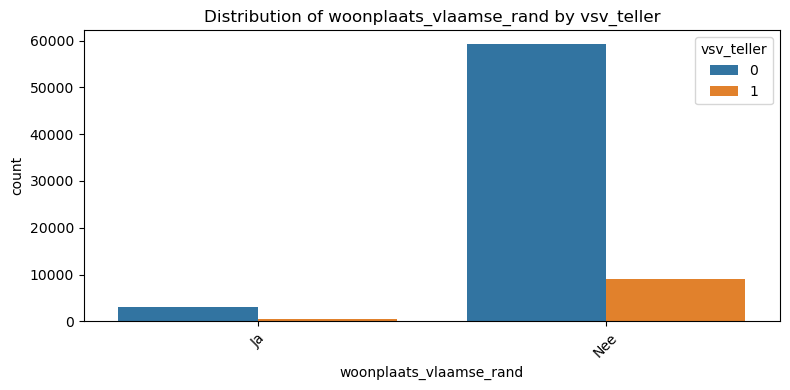

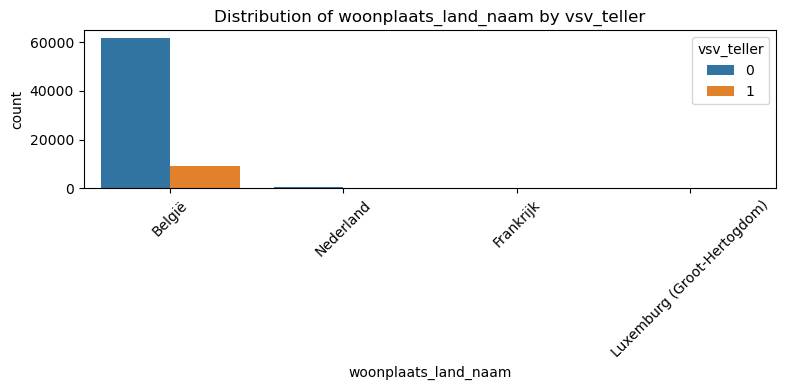


🧮 Correlation Matrix:


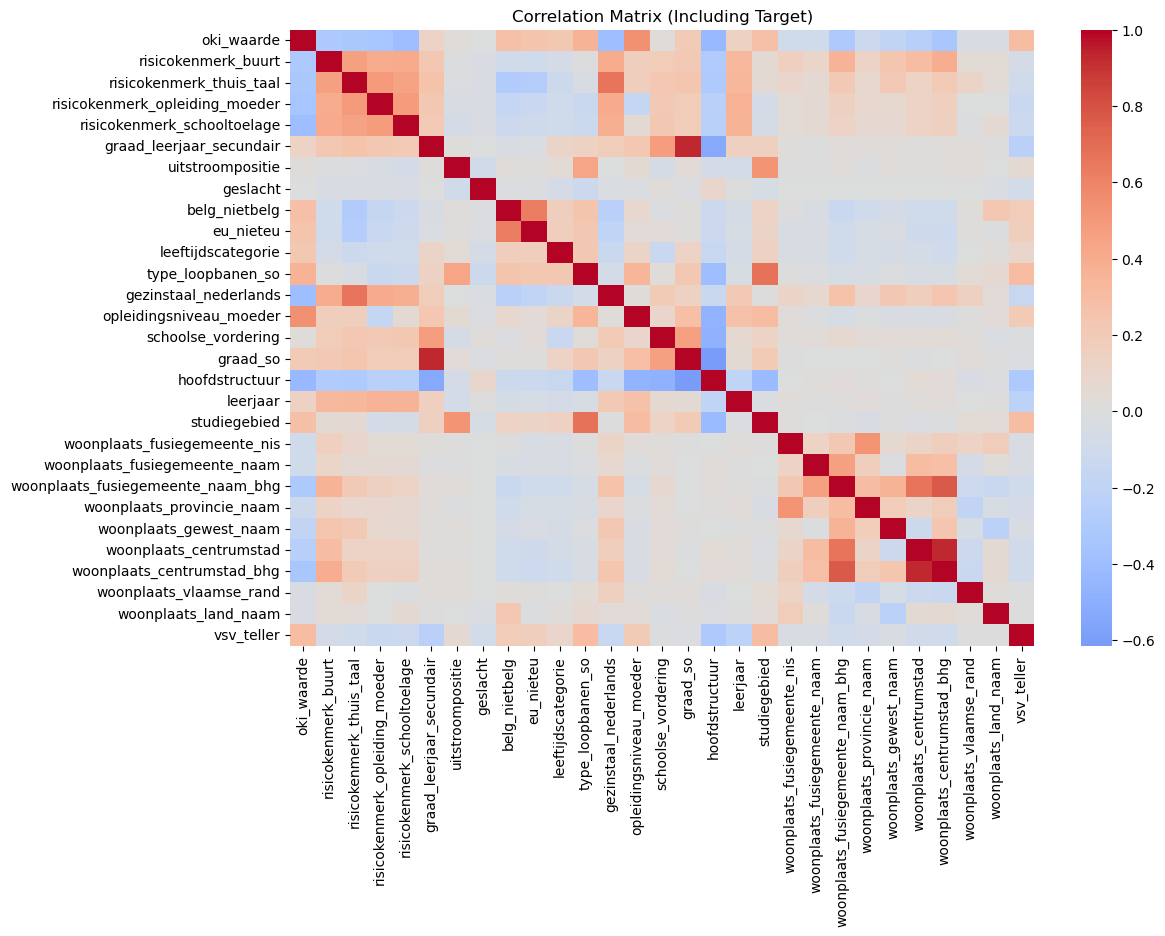


📊 VIF Analysis (Multicollinearity / Proxies):

🔍 VIF Scores:
                              feature         VIF
2            risicokenmerk_thuis_taal   13.311423
5            graad_leerjaar_secundair  223.217573
15                           graad_so  505.145278
16                     hoofdstructuur   61.867637
17                           leerjaar   19.358852
21  woonplaats_fusiegemeente_naam_bhg   29.385781
23             woonplaats_gewest_naam  226.246216
24             woonplaats_centrumstad  198.141017
25         woonplaats_centrumstad_bhg  184.428335
26            woonplaats_vlaamse_rand   24.857483


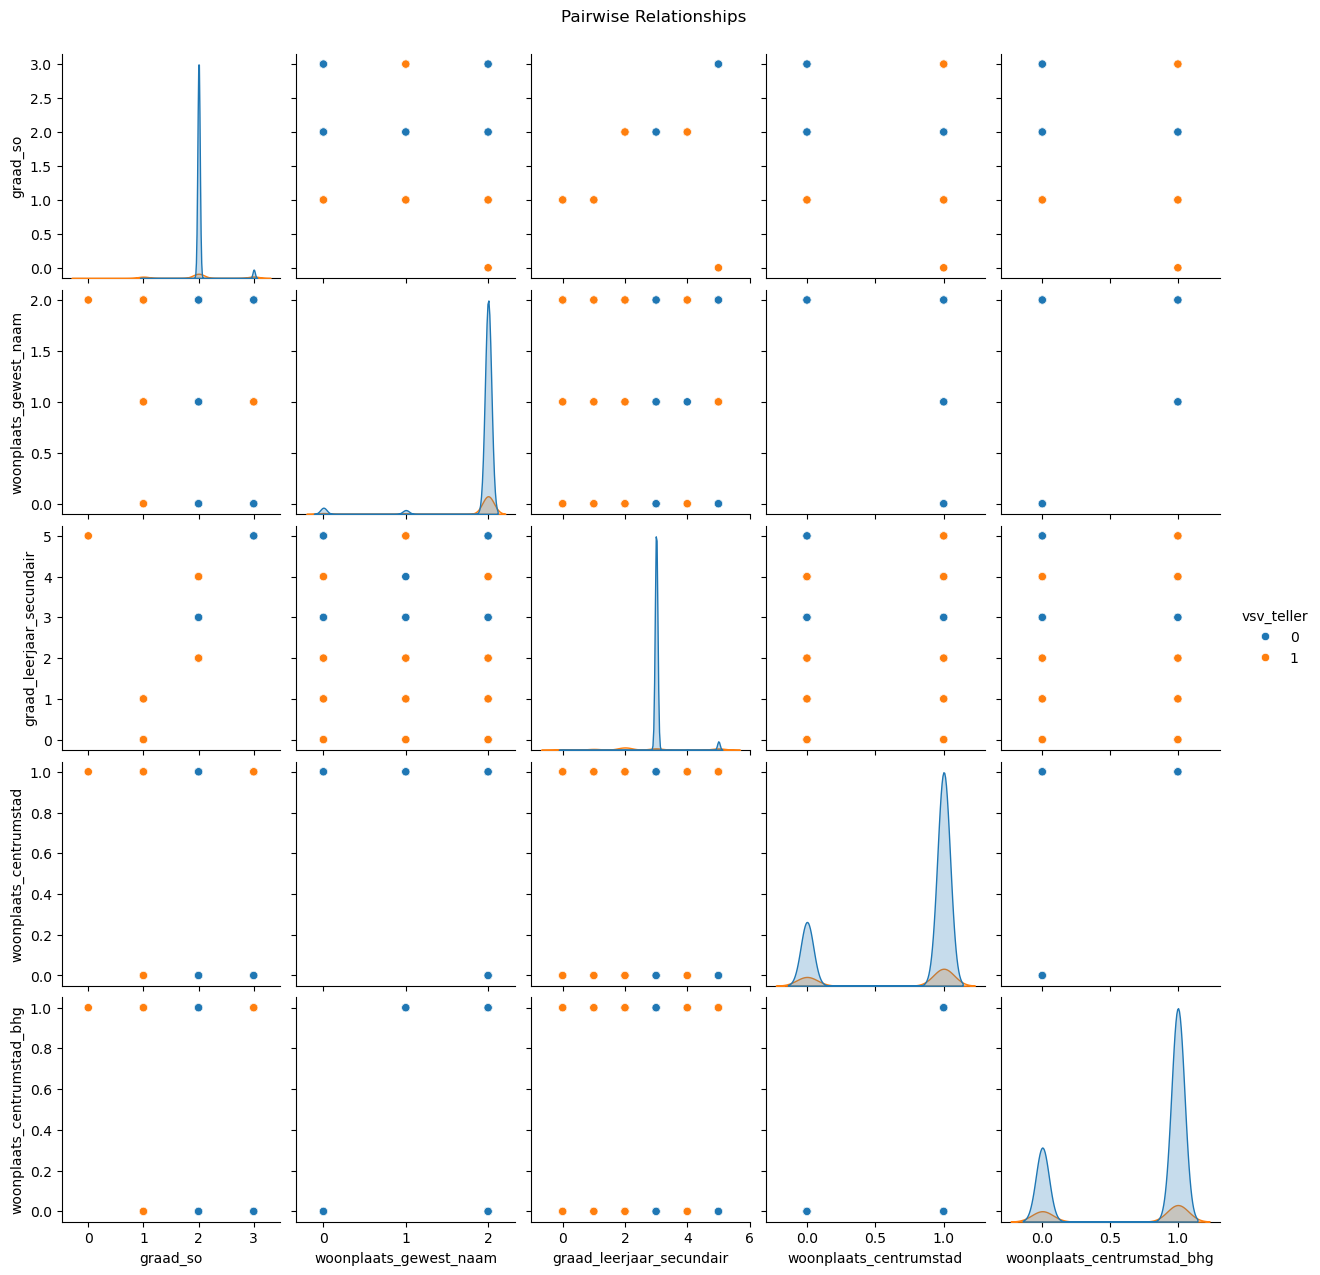

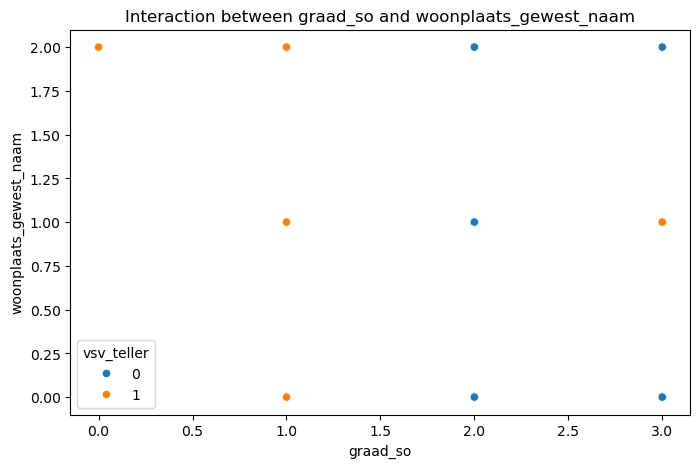

In [20]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import itertools

# Helper to encode categorical vars temporarily
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

target = 'vsv_teller'

# 1. Distribution per target class
def plot_distributions_per_class(df, target):
    features = df.drop(columns=[target]).columns
    for col in features:
        plt.figure(figsize=(8, 4))
        if df[col].dtype == 'object':
            sns.countplot(data=df, x=col, hue=target)
            plt.title(f"Distribution of {col} by {target}")
            plt.xticks(rotation=45)
        else:
            sns.histplot(data=df, x=col, hue=target, kde=True, bins=20, multiple="stack")
            plt.title(f"Distribution of {col} by {target}")
        plt.tight_layout()
        plt.show()

# 2. Correlation matrix for all variables
def plot_correlation_matrix(df_encoded):
    corr = df_encoded.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f", center=0)
    plt.title("Correlation Matrix (Including Target)")
    plt.show()

# 3. Pairplot for selected variables (to visualize nonlinearities or interactions)
def pairplot_subset(df, columns):
    sns.pairplot(df[columns + [target]], hue=target, diag_kind='kde')
    plt.suptitle("Pairwise Relationships", y=1.02)
    plt.show()

# 4. VIF (Variance Inflation Factor) for multicollinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df_encoded, threshold=10):
    X = df_encoded.drop(columns=[target])
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\n VIF Scores:")
    print(vif_data[vif_data['VIF'] > threshold])
    return vif_data

# 5. Interaction effect (optional)
def plot_3way_interaction(df, col1, col2):
    if df[col1].dtype != 'object' and df[col2].dtype != 'object':
        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=df, x=col1, y=col2, hue=target)
        plt.title(f"Interaction between {col1} and {col2}")
        plt.show()

# Run everything
print(" Distributions per Target Class:")
plot_distributions_per_class(df, target)

print("\n Correlation Matrix:")
plot_correlation_matrix(df_encoded)

print("\n VIF Analysis (Multicollinearity / Proxies):")
vif_scores = calculate_vif(df_encoded)

# Select some variables for deeper pairwise analysis
selected_features = vif_scores.sort_values(by='VIF', ascending=False)['feature'].head(5).tolist()
pairplot_subset(df_encoded, selected_features)

# Example: plot one 3-way interaction (you can add more if needed)
plot_3way_interaction(df_encoded, selected_features[0], selected_features[1])


<h1>Check for inconsistency</h1>

In [23]:
def detect_inconsistencies(df, target='vsv_teller'):
    print("\n Checking for label inconsistencies...")

    # All columns except target
    feature_cols = [col for col in df.columns if col != target]

    # Group by features and count the number of different target values
    grouped = df.groupby(feature_cols)[target].nunique().reset_index()
    inconsistent_rows = grouped[grouped[target] > 1]

    num_inconsistent_patterns = inconsistent_rows.shape[0]
    total_patterns = grouped.shape[0]
    total_rows = df.shape[0]

    print(f" Found {num_inconsistent_patterns} inconsistent feature patterns out of {total_patterns} total unique feature patterns.")
    print(f"→ This affects ~{(num_inconsistent_patterns / total_patterns) * 100:.2f}% of patterns in your dataset.")
    
    # Now count how many *rows* this actually affects
    inconsistent_features_df = df.merge(inconsistent_rows.drop(columns=[target]), on=feature_cols, how='inner')
    print(f" Number of inconsistent data rows: {inconsistent_features_df.shape[0]} out of {total_rows} total rows.")

    return inconsistent_features_df

# Run it
inconsistent_df = detect_inconsistencies(df)

# Preview a few examples
if not inconsistent_df.empty:
    print("\n Sample inconsistent rows:")
    display(inconsistent_df.head(5))

def flag_inconsistent_features(inconsistent_df, target='vsv_teller'):
    feature_cols = [col for col in inconsistent_df.columns if col != target]
    print("\n Checking which features appear most in inconsistencies:")

    for col in feature_cols:
        unique_vals = inconsistent_df[col].nunique()
        total_vals = df[col].nunique()
        print(f"- {col}: {unique_vals} unique values involved in inconsistent rows (out of {total_vals})")

# Run this if `inconsistent_df` has content
if not inconsistent_df.empty:
    flag_inconsistent_features(inconsistent_df)



 Checking for label inconsistencies...
 Found 505 inconsistent feature patterns out of 48997 total unique feature patterns.
→ This affects ~1.03% of patterns in your dataset.
 Number of inconsistent data rows: 3345 out of 71668 total rows.

 Sample inconsistent rows:


oki_waarde risicokenmerk_buurt risicokenmerk_thuis_taal  \
0          1                 Nee                      Nee   
1          1                 Nee                      Nee   
2        3,4                  Ja                       Ja   
3        3,4                  Ja                       Ja   
4          1                 Nee                      Nee   

  risicokenmerk_opleiding_moeder risicokenmerk_schooltoelage  \
0                            Nee                          Ja   
1                            Nee                          Ja   
2                             Ja                          Ja   
3                             Ja                          Ja   
4                            Nee                          Ja   

  graad_leerjaar_secundair uitstroompositie    geslacht belg_nietbelg  \
0                   n.v.t.             dbso   Mannelijk          Belg   
1                   n.v.t.             dbso   Mannelijk          Belg   
2   3e graad - 2e leerjaar              tso  Vrouwelijk          Belg   
3   3e graad - 2e leerjaar              tso  Vrouwelijk          Belg   
4   3e graad - 2e leerjaar              tso   Mannelijk          Belg   

  eu_nieteu  ... woonplaats_fusiegemeente_nis woonplaats_fusiegemeente_naam  \
0        EU  ...                        13040                      Turnhout   
1        EU  ...                        13040                      Turnhout   
2        EU  ...                        11002                     Antwerpen   
3        EU  ...                        11002                     Antwerpen   
4        EU  ...                        71066                      Zonhoven   

  woonplaats_fusiegemeente_naam_bhg woonplaats_provincie_naam  \
0                          Turnhout                 Antwerpen   
1                          Turnhout                 Antwerpen   
2                         Antwerpen                 Antwerpen   
3                         Antwerpen                 Antwerpen   
4      Overige (niet-centrumsteden)                   Limburg   

  woonplaats_gewest_naam woonplaats_centrumstad woonplaats_centrumstad_bhg  \
0          Vlaams Gewest                     Ja                         Ja   
1          Vlaams Gewest                     Ja                         Ja   
2          Vlaams Gewest                     Ja                         Ja   
3          Vlaams Gewest                     Ja                         Ja   
4          Vlaams Gewest                    Nee                        Nee   

  woonplaats_vlaamse_rand woonplaats_land_naam vsv_teller  
0                     Nee               België          1  
1                     Nee               België          0  
2                     Nee               België          1  
3                     Nee               België          0  
4                     Nee               België          1  

[5 rows x 29 columns]


 Checking which features appear most in inconsistencies:
- oki_waarde: 5 unique values involved in inconsistent rows (out of 5)
- risicokenmerk_buurt: 3 unique values involved in inconsistent rows (out of 3)
- risicokenmerk_thuis_taal: 3 unique values involved in inconsistent rows (out of 3)
- risicokenmerk_opleiding_moeder: 3 unique values involved in inconsistent rows (out of 3)
- risicokenmerk_schooltoelage: 3 unique values involved in inconsistent rows (out of 3)
- graad_leerjaar_secundair: 2 unique values involved in inconsistent rows (out of 6)
- uitstroompositie: 8 unique values involved in inconsistent rows (out of 9)
- geslacht: 2 unique values involved in inconsistent rows (out of 2)
- belg_nietbelg: 2 unique values involved in inconsistent rows (out of 2)
- eu_nieteu: 2 unique values involved in inconsistent rows (out of 2)
- leeftijdscategorie: 6 unique values involved in inconsistent rows (out of 7)
- type_loopbanen_so: 9 unique values involved in inconsistent rows (out o

<h1>protected groups</h1>

In [26]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def fairness_analysis(X_test, y_test, y_pred, protected_features):
    X_test_copy = X_test.copy()
    X_test_copy['true'] = y_test.values
    X_test_copy['pred'] = y_pred

    for feature in protected_features:
        print(f"\n Fairness Analysis by: {feature}")
        for group in X_test_copy[feature].unique():
            subset = X_test_copy[X_test_copy[feature] == group]
            if subset.shape[0] < 10:
                print(f"  Skipping group '{group}' due to too few samples.")
                continue

            y_true = subset['true']
            y_group_pred = subset['pred']

            tn, fp, fn, tp = confusion_matrix(y_true, y_group_pred).ravel()
            precision = precision_score(y_true, y_group_pred, zero_division=0)
            recall = recall_score(y_true, y_group_pred, zero_division=0)
            f1 = f1_score(y_true, y_group_pred, zero_division=0)
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

            print(f"  Group '{group}' (n={len(subset)}):")
            print(f"    TP={tp}, FP={fp}, FN={fn}, TN={tn}")
            print(f"    Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
            print(f"    FPR: {fpr:.3f} | FNR: {fnr:.3f}")


In [27]:
# List of protected attributes you want to check fairness for
protected_attrs = ['geslacht', 'belg_nietbelg', 'eu_nieteu', 'woonplaats_provincie_naam', 'leeftijdscategorie', 'opleidingsniveau_moeder', 'schoolse_vordering']

# Make sure these features are in the test set (might need to keep a copy before encoding!)
fairness_analysis(X_test, y_test, y_pred, protected_attrs)



 Fairness Analysis by: geslacht
  Group 'Vrouwelijk' (n=6900):
    TP=506, FP=128, FN=184, TN=6082
    Precision: 0.798 | Recall: 0.733 | F1: 0.764
    FPR: 0.021 | FNR: 0.267
  Group 'Mannelijk' (n=7434):
    TP=914, FP=211, FN=286, TN=6023
    Precision: 0.812 | Recall: 0.762 | F1: 0.786
    FPR: 0.034 | FNR: 0.238

 Fairness Analysis by: belg_nietbelg
  Group 'Belg' (n=13089):
    TP=1084, FP=261, FN=393, TN=11351
    Precision: 0.806 | Recall: 0.734 | F1: 0.768
    FPR: 0.022 | FNR: 0.266
  Group 'niet-Belg' (n=1245):
    TP=336, FP=78, FN=77, TN=754
    Precision: 0.812 | Recall: 0.814 | F1: 0.813
    FPR: 0.094 | FNR: 0.186

 Fairness Analysis by: eu_nieteu
  Group 'EU' (n=13807):
    TP=1236, FP=299, FN=431, TN=11841
    Precision: 0.805 | Recall: 0.741 | F1: 0.772
    FPR: 0.025 | FNR: 0.259
  Group 'niet-EU' (n=527):
    TP=184, FP=40, FN=39, TN=264
    Precision: 0.821 | Recall: 0.825 | F1: 0.823
    FPR: 0.132 | FNR: 0.175

 Fairness Analysis by: woonplaats_provincie_naam
 

<h1>fairness</h1>

<h3>group fairness</h3>

In [28]:
def compute_group_fairness_summary(X_test, y_test, y_pred, protected_attr):
    results = []
    for attr in protected_attr:
        groups = X_test[attr].unique()
        for group in groups:
            mask = X_test[attr] == group
            if mask.sum() < 10:
                continue
            y_true_g = y_test[mask]
            y_pred_g = y_pred[mask]

            tp = ((y_true_g == 1) & (y_pred_g == 1)).sum()
            fn = ((y_true_g == 1) & (y_pred_g == 0)).sum()
            fp = ((y_true_g == 0) & (y_pred_g == 1)).sum()
            tn = ((y_true_g == 0) & (y_pred_g == 0)).sum()

            positive_rate = (y_pred_g == 1).mean()
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

            results.append({
                'Feature': attr,
                'Group': group,
                'Samples': mask.sum(),
                'Positive Rate': round(positive_rate, 3),
                'Recall': round(recall, 3),
                'FPR': round(fpr, 3)
            })
    return pd.DataFrame(results)


C:\Users\mouni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


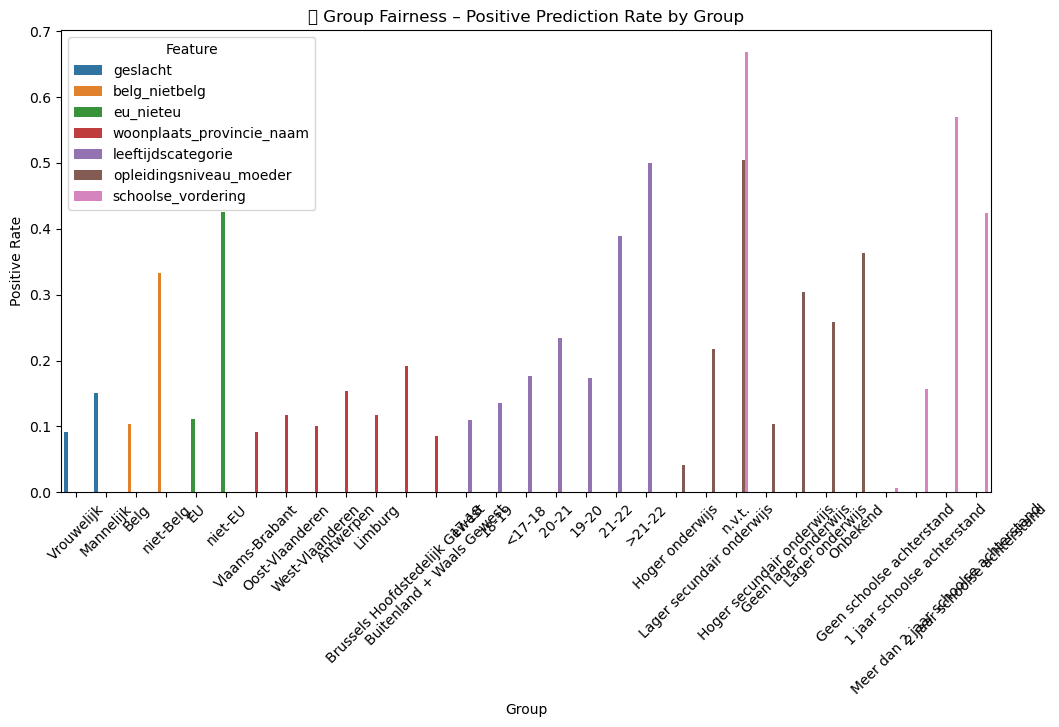

In [29]:
group_fairness_df = compute_group_fairness_summary(X_test, y_test, y_pred, protected_attrs)
import seaborn as sns
import matplotlib.pyplot as plt

# Plot disparities for Positive Rate
plt.figure(figsize=(12, 6))
sns.barplot(data=group_fairness_df, x='Group', y='Positive Rate', hue='Feature')
plt.xticks(rotation=45)
plt.title("📊 Group Fairness – Positive Prediction Rate by Group")
plt.show()


<h3>individual fairness</h3>

In [30]:
from sklearn.neighbors import NearestNeighbors

def check_individual_fairness(X_test, y_pred, k=3):
    model = NearestNeighbors(n_neighbors=k+1)  # +1 because point is its own nearest neighbor
    model.fit(X_test)
    distances, indices = model.kneighbors(X_test)

    inconsistencies = 0
    total = 0

    for i, neighbors in enumerate(indices):
        own_pred = y_pred[i]
        neighbor_preds = y_pred[neighbors[1:]]  # skip self
        inconsistencies += (neighbor_preds != own_pred).sum()
        total += len(neighbor_preds)

    print(f"🔬 Individual Fairness Proxy:")
    print(f"Inconsistent predictions among neighbors: {inconsistencies}/{total} ({(inconsistencies / total):.2%})")

# Preprocess first (X_test must be numeric)
X_test_num = preprocessor.transform(X_test)
check_individual_fairness(X_test_num, y_pred)


🔬 Individual Fairness Proxy:
Inconsistent predictions among neighbors: 1798/43002 (4.18%)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import pandas as pd
import numpy as np

# === Load the transformed dataset ===
file_path = "vroegtijdig-schoolverlaten-woonplaats-dataset-2022-2023.xlsx"
bad_df = pd.read_excel(file_path)

def transform_dataset(bad_df):
    transformed_rows = []
    for _, row in bad_df.iterrows():
        vsv_noemer = row['vsv_noemer']
        vsv_teller = row['vsv_teller']
        for i in range(vsv_noemer):
            new_row = row.copy()
            new_row['vsv_teller'] = 1 if i < vsv_teller else 0
            transformed_rows.append(new_row)
    df = pd.DataFrame(transformed_rows)
    df = df.drop(columns=['vsv_noemer'])
    return df

df = transform_dataset(bad_df)

# Drop unnecessary column
if 'schooljaar' in df.columns:
    df.drop(columns=['schooljaar'], inplace=True)

# Separate features and target
X = df.drop(columns=['vsv_teller'])
y = df['vsv_teller']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Define columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['number']).columns

# Define preprocessor
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_cols)
], remainder='passthrough')

# Define resampling steps
over = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.8, random_state=42)

# Define models
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
xgb_model = xgb.XGBClassifier(scale_pos_weight=3, use_label_encoder=False, eval_metric='logloss')

# Pipelines
models = {
    "Baseline_RF": Pipeline([('preprocess', preprocessor), ('clf', rf)]),
    "BiasMitigated_RF": ImbPipeline([('preprocess', preprocessor), ('over', over), ('under', under), ('clf', rf)]),
    "BiasMitigated_LogReg": ImbPipeline([('preprocess', preprocessor), ('over', over), ('under', under), ('clf', logreg)]),
    "BiasMitigated_XGBoost": Pipeline([('preprocess', preprocessor), ('clf', xgb_model)]),
}

# Evaluate all models
def evaluate_all_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, pipeline in models.items():
        print(f"\n📦 Training model: {name}")
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None

        acc = np.mean(y_pred == y_test)
        auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
        report = classification_report(y_test, y_pred, output_dict=True)

        results[name] = {
            'model': pipeline,
            'y_pred': y_pred,
            'y_proba': y_proba,
            'accuracy': acc,
            'roc_auc': auc,
            'report': report
        }

        print(f"→ Accuracy: {acc:.4f}")
        if auc:
            print(f"→ ROC AUC: {auc:.4f}")
        print(classification_report(y_test, y_pred))
    return results

model_results = evaluate_all_models(models, X_train, X_test, y_train, y_test)



📦 Training model: Baseline_RF
→ Accuracy: 0.9468
→ ROC AUC: 0.9303
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     12444
           1       0.85      0.73      0.78      1890

    accuracy                           0.95     14334
   macro avg       0.90      0.85      0.88     14334
weighted avg       0.94      0.95      0.95     14334


📦 Training model: BiasMitigated_RF
→ Accuracy: 0.9436
→ ROC AUC: 0.9361
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     12444
           1       0.81      0.75      0.78      1890

    accuracy                           0.94     14334
   macro avg       0.88      0.86      0.87     14334
weighted avg       0.94      0.94      0.94     14334


📦 Training model: BiasMitigated_LogReg
→ Accuracy: 0.9103
→ ROC AUC: 0.9400
              precision    recall  f1-score   support

           0       0.97      0.92      0.95     12444
           1       

C:\Users\mouni\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


→ Accuracy: 0.9419
→ ROC AUC: 0.9450
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     12444
           1       0.78      0.78      0.78      1890

    accuracy                           0.94     14334
   macro avg       0.87      0.87      0.87     14334
weighted avg       0.94      0.94      0.94     14334



In [11]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

protected_attrs = ['geslacht', 'belg_nietbelg', 'eu_nieteu', 'woonplaats_provincie_naam', 'leeftijdscategorie', 'opleidingsniveau_moeder', 'schoolse_vordering']

def fairness_analysis(X_test, y_test, y_pred, protected_features):
    X_test_copy = X_test.copy()
    X_test_copy['true'] = y_test.values
    X_test_copy['pred'] = y_pred

    for feature in protected_features:
        print(f"\n Fairness Analysis by: {feature}")
        for group in X_test_copy[feature].unique():
            subset = X_test_copy[X_test_copy[feature] == group]
            if subset.shape[0] < 10:
                print(f"  Skipping group '{group}' due to too few samples.")
                continue

            y_true = subset['true']
            y_group_pred = subset['pred']

            tn, fp, fn, tp = confusion_matrix(y_true, y_group_pred).ravel()
            precision = precision_score(y_true, y_group_pred, zero_division=0)
            recall = recall_score(y_true, y_group_pred, zero_division=0)
            f1 = f1_score(y_true, y_group_pred, zero_division=0)
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

            print(f"  Group '{group}' (n={len(subset)}):")
            print(f"    TP={tp}, FP={fp}, FN={fn}, TN={tn}")
            print(f"    Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
            print(f"    FPR: {fpr:.3f} | FNR: {fnr:.3f}")

def compare_fairness(model_results, X_test, y_test, protected_attrs):
    for model_name, data in model_results.items():
        print(f"\n=== Fairness Evaluation for: {model_name} ===")
        y_pred = data['y_pred']
        fairness_analysis(X_test, y_test, y_pred, protected_attrs)

In [12]:
compare_fairness(model_results, X_test, y_test, protected_attrs)


=== Fairness Evaluation for: Baseline_RF ===

 Fairness Analysis by: geslacht
  Group 'Vrouwelijk' (n=6900):
    TP=487, FP=89, FN=203, TN=6121
    Precision: 0.845 | Recall: 0.706 | F1: 0.769
    FPR: 0.014 | FNR: 0.294
  Group 'Mannelijk' (n=7434):
    TP=885, FP=155, FN=315, TN=6079
    Precision: 0.851 | Recall: 0.738 | F1: 0.790
    FPR: 0.025 | FNR: 0.263

 Fairness Analysis by: belg_nietbelg
  Group 'Belg' (n=13089):
    TP=1046, FP=198, FN=431, TN=11414
    Precision: 0.841 | Recall: 0.708 | F1: 0.769
    FPR: 0.017 | FNR: 0.292
  Group 'niet-Belg' (n=1245):
    TP=326, FP=46, FN=87, TN=786
    Precision: 0.876 | Recall: 0.789 | F1: 0.831
    FPR: 0.055 | FNR: 0.211

 Fairness Analysis by: eu_nieteu
  Group 'EU' (n=13807):
    TP=1197, FP=223, FN=470, TN=11917
    Precision: 0.843 | Recall: 0.718 | F1: 0.776
    FPR: 0.018 | FNR: 0.282
  Group 'niet-EU' (n=527):
    TP=175, FP=21, FN=48, TN=283
    Precision: 0.893 | Recall: 0.785 | F1: 0.835
    FPR: 0.069 | FNR: 0.215

 Fair